Here we'll first be loading the FC matrices and explore their structure

In [1]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset_MDD
import torch 
print('GPU available?', torch.cuda.is_available())

GPU available? True


In [2]:
dataset = read_dataset_MDD()

In [3]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has MDD
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
print('Number of samples:', len(dataset))


Data(x=[116, 116], edge_index=[2, 1294], edge_attr=[1294, 1], y=[1])
['edge_index', 'y', 'edge_attr', 'x']
ValuesView({'x': tensor([[ 0.0000,  0.2857,  0.0804,  ...,  0.2032,  0.1674,  0.0906],
        [ 0.2857,  0.0000, -0.3860,  ...,  0.1637, -0.0359,  0.1674],
        [ 0.0804, -0.3860,  0.0000,  ..., -0.0175, -0.0309,  0.0296],
        ...,
        [ 0.2032,  0.1637, -0.0175,  ...,  0.0000,  0.2329, -0.1452],
        [ 0.1674, -0.0359, -0.0309,  ...,  0.2329,  0.0000,  0.0183],
        [ 0.0906,  0.1674,  0.0296,  ..., -0.1452,  0.0183,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 113, 113, 114],
        [ 10,  12,  14,  ..., 111, 112, 108]]), 'edge_attr': tensor([[0.7785],
        [0.6966],
        [0.5463],
        ...,
        [0.6415],
        [0.4745],
        [0.5401]]), 'y': tensor([0])})
Number of samples: 1604


In [4]:
#set the seed
import torch
torch.manual_seed(0)

MODEL = "GCN"
DATASET = "FC_MDD"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

gnn = framework(dataset)

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1): GCNConv(128, 128)
    (2): GCNConv(128, 128)
    (3): GCNConv(128, 128)
    (4): GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm(128)
    (1): BatchNorm(128)
    (2): BatchNorm(128)
    (3): BatchNorm(128)
    (4): BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([1365,  984, 1017,  ...,  260,  678,   83])


/home/tpelletreaudur/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
# gnn.iterate()

In [6]:
#gnn.train()

In [7]:
#save the model 
#gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [6]:
#load the model
# gnn.load_model(path="models/"+DATASET+"_"+MODEL+"_computer.pt")

In [ ]:
#save the model 
#gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [5]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server_gpu.pt")

In [6]:
gnn.evaluate()

Test Loss: 0.649, Train Acc: 1.000 Test Acc: 0.605


In [7]:
train_features, test_features = gnn.evaluate_with_features2()

In [14]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1523, 81)

In [8]:
import pickle as pkl
import networkx as nx

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
def calculate_small_world(G):
    if nx.is_connected(G):
        return nx.algorithms.smallworld.sigma(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the small world coefficient of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.algorithms.smallworld.sigma(largest_component)
    
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        assortativity = nx.degree_assortativity_coefficient(G)
        small_world = compute_swi(G)
            
        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component, assortativity, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

# Save the properties to files
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [16]:
print(len(train_properties))
train_properties[0:5]



1523


[(116,
  488,
  0.07316341829085457,
  3.314842578710645,
  148,
  938.0,
  6.439699892510922,
  116),
 (114,
  598,
  0.0928427262847384,
  3.166744294364229,
  164,
  1378.0,
  7.519630514954544,
  114),
 (114,
  408,
  0.06334420121099209,
  3.391864617295451,
  135,
  511.0,
  5.279502013122494,
  114),
 (115,
  744,
  0.11350114416475973,
  2.796796338672769,
  198,
  1870.0,
  7.980704583203741,
  115),
 (112,
  706,
  0.11357786357786358,
  3.3745173745173744,
  181,
  2528.0,
  9.050100863174576,
  112)]

In [9]:
import pickle as pkl
# save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_with_sm.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_with_sm.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [10]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/800000], Property: num_nodes, Loss: 11341.2871
Epoch [2000/800000], Property: num_nodes, Loss: 10082.5352
Epoch [3000/800000], Property: num_nodes, Loss: 9039.9912
Epoch [4000/800000], Property: num_nodes, Loss: 8154.3652
Epoch [5000/800000], Property: num_nodes, Loss: 7387.4019
Epoch [6000/800000], Property: num_nodes, Loss: 6718.8745
Epoch [7000/800000], Property: num_nodes, Loss: 6135.7793
Epoch [8000/800000], Property: num_nodes, Loss: 5628.4307
Epoch [9000/800000], Property: num_nodes, Loss: 5187.0342
Epoch [10000/800000], Property: num_nodes, Loss: 4801.5547
Epoch [11000/800000], Property: num_nodes, Loss: 4462.5332
Epoch [12000/800000], Property: num_nodes, Loss: 4162.6948
Epoch [13000/800000], Property: num_nodes, Loss: 3898.1255
Epoch [14000/800000], Property: num_nodes, Loss: 3665.4441
Epoch [15000/800000], Property: num_nodes, Loss: 3460.3237
Epoch [16000/800000], Property: num_nodes, Loss: 3279.0203
Epoch [17000/800000], Property: num_nodes, Loss: 3118.6458
Epoc

In [ ]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "rb") as f:
    results = pkl.load(f)

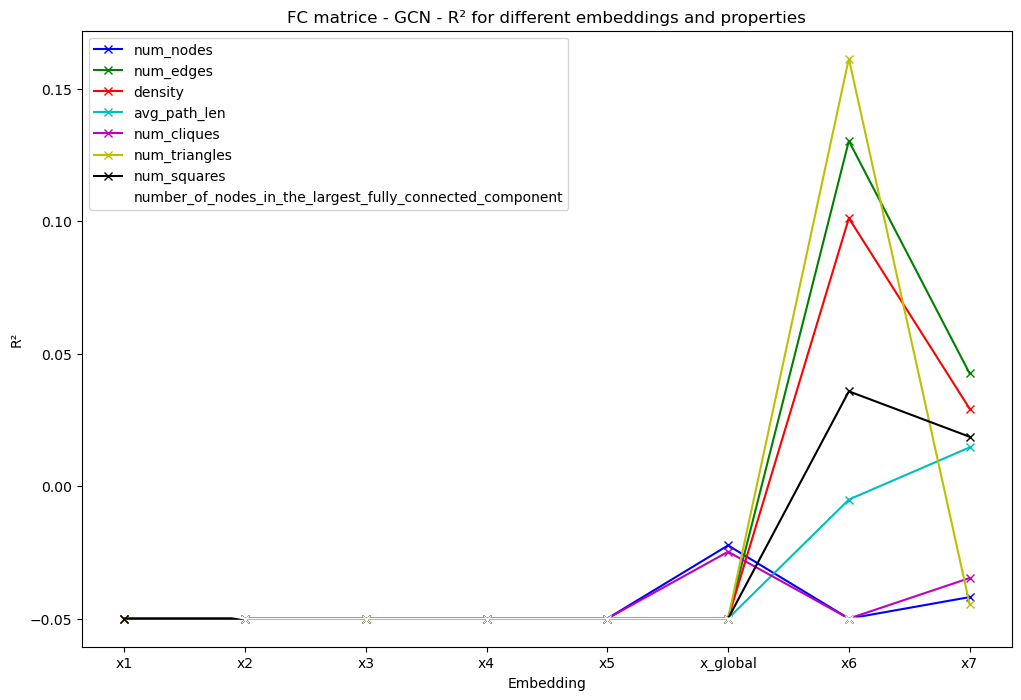

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

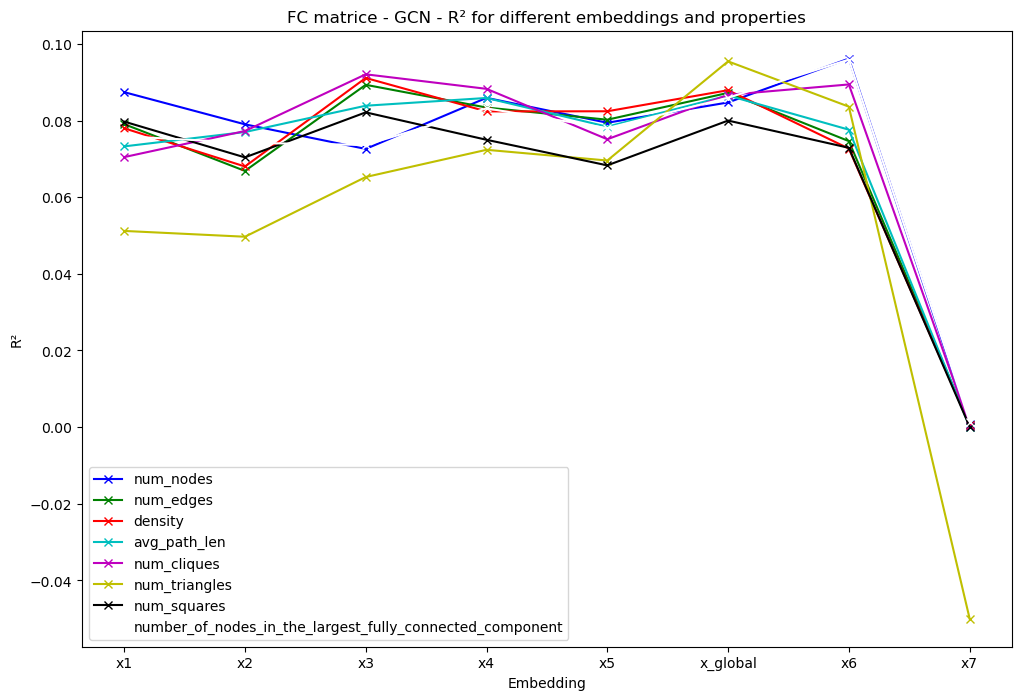

<Figure size 640x480 with 0 Axes>

In [21]:
# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'assortativity', 'small_world']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

#### Test with more properties

In [11]:
import networkx as nx
import numpy as np

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Use the average path length of the largest connected component for disconnected graphs
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
   
def compute_swi(graph):
    # Calculate clustering coefficient and average path length for the given graph
    clustering_coeff = nx.average_clustering(graph)
    avg_path_len = calculate_avg_path_length(graph)
    
    # Generate a random graph with the same number of nodes and edges
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    random_graph = nx.gnm_random_graph(num_nodes, num_edges)
    
    # Generate a lattice graph with the same number of nodes and edges
    lattice_graph = nx.watts_strogatz_graph(num_nodes, k=4, p=0)  # Adjust k as needed
    
    # Calculate clustering coefficient and average path length for the random graph
    random_clustering_coeff = nx.average_clustering(random_graph)
    random_avg_path_len = calculate_avg_path_length(random_graph)
    
    # Calculate clustering coefficient and average path length for the lattice graph
    lattice_clustering_coeff = nx.average_clustering(lattice_graph)
    lattice_avg_path_len = calculate_avg_path_length(lattice_graph)
    
    # Compute the Small-World Index (SWI)
    swi = ((avg_path_len - lattice_avg_path_len) / (random_avg_path_len - lattice_avg_path_len)) * \
          ((clustering_coeff - random_clustering_coeff) / (lattice_clustering_coeff - random_clustering_coeff))
    
    return swi


def betweenness_centralization(G):
    n = len(G)
    betweenness = nx.betweenness_centrality(G)
    max_betweenness = max(betweenness.values())
    centralization = sum(max_betweenness - bet for bet in betweenness.values())
    if n > 2:
        centralization /= (n - 1) * (n - 2) / 2
    return centralization

def pagerank_centralization(G, alpha=0.85):
    n = len(G)
    pagerank = nx.pagerank(G, alpha=alpha)
    max_pagerank = max(pagerank.values())
    centralization = sum(max_pagerank - pr for pr in pagerank.values())
    if n > 1:
        centralization /= (n - 1)
    return centralization

def clustering_properties(G):
    average_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    return average_clustering, transitivity

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Number of nodes
        num_nodes = G.number_of_nodes()
        
        # Number of edges
        num_edges = G.number_of_edges()
        
        # Density
        density = nx.density(G)
        
        # Average Path Length
        avg_path_len = calculate_avg_path_length(G)
        
        # Diameter
        if nx.is_connected(G):
            diameter = nx.diameter(G)
        else:
            # Use the diameter of the largest connected component for disconnected graphs
            components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            largest_component = max(components, key=len)
            diameter = nx.diameter(largest_component)
        
        # Radius
        if nx.is_connected(G):
            radius = nx.radius(G)
        else:
            radius = nx.radius(largest_component)
        
        # Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        
        # Transitivity
        transitivity = nx.transitivity(G)
        
        # Assortativity
        assortativity = nx.degree_assortativity_coefficient(G)
        
        # Number of Cliques
        num_cliques = len(list(nx.find_cliques(G)))
        
        # Number of Triangles
        num_triangles = sum(nx.triangles(G).values()) / 3
        
        # Number of Squares (4-cycles)
        num_squares = sum(nx.square_clustering(G).values()) / 4
        
        # Size of the Largest Connected Component
        largest_component_size = len(max(nx.connected_components(G), key=len))
        
        # Average Degree
        degrees = [d for n, d in G.degree()]
        avg_degree = np.mean(degrees)
        
        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(G)
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
        
        # Eigenvalues of the Adjacency Matrix (for spectral properties)
        eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(G).todense())
        spectral_radius = max(eigenvalues)
        algebraic_connectivity = sorted(eigenvalues)[1]  # second smallest eigenvalue
        
        # Graph Laplacian Eigenvalues
        laplacian_eigenvalues = np.linalg.eigvals(nx.laplacian_matrix(G).todense())
        graph_energy = sum(abs(laplacian_eigenvalues))
        
        # Small-World-ness
        # Compare clustering coefficient and average path length with those of a random graph
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        random_clustering_coeff = nx.average_clustering(random_graph)
        random_avg_path_len = calculate_avg_path_length(random_graph)
        small_world_coefficient = (clustering_coeff / random_clustering_coeff) / (avg_path_len / random_avg_path_len)

        small_world_index = compute_swi(G)

        # Calculate Betweenness Centralization
        betweenness_cent = betweenness_centralization(G)
        print(f"Betweenness Centralization: {betweenness_cent}")

        # Calculate PageRank Centralization
        pagerank_cent = pagerank_centralization(G)
        print(f"PageRank Centralization: {pagerank_cent}")

        # Calculate Clustering properties
        avg_clustering, transitivity = clustering_properties(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        print(f"Transitivity: {transitivity}")
        
        properties.append((
            num_nodes,
            num_edges,
            density,
            avg_path_len,
            diameter,
            radius,
            clustering_coeff,
            transitivity,
            assortativity,
            num_cliques,
            num_triangles,
            num_squares,
            largest_component_size,
            avg_degree,
            avg_betweenness_centrality,
            spectral_radius,
            algebraic_connectivity,
            graph_energy,
            small_world_coefficient, 
            betweenness_cent,
            pagerank_cent,
            avg_clustering,
            small_world_index           

        ))
    return properties


train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)



Betweenness Centralization: 0.001724022477030078
PageRank Centralization: 0.011393522233220854
Average Clustering Coefficient: 0.46590185426058695
Transitivity: 0.5531747591900924
Betweenness Centralization: 0.0017261983853566708
PageRank Centralization: 0.008926832657320428
Average Clustering Coefficient: 0.5182009816568728
Transitivity: 0.5797223390828776
Betweenness Centralization: 0.003333083015572392
PageRank Centralization: 0.015313849504207902
Average Clustering Coefficient: 0.4704590487485227
Transitivity: 0.4714022140221402
Betweenness Centralization: 0.0010671877568257148
PageRank Centralization: 0.005223720319742302
Average Clustering Coefficient: 0.5604119583322708
Transitivity: 0.5464108308171812
Betweenness Centralization: 0.0022241433151757965
PageRank Centralization: 0.010110693464664746
Average Clustering Coefficient: 0.5817108880061148
Transitivity: 0.6164350158497928
Betweenness Centralization: 0.0008253715900658974
PageRank Centralization: 0.008937849000785932
Avera

Betweenness Centralization: 0.001078428822044226
PageRank Centralization: 0.009063561996750147
Average Clustering Coefficient: 0.5532543094005744
Transitivity: 0.5523364485981308
Betweenness Centralization: 0.001653614405354768
PageRank Centralization: 0.007032983882622251
Average Clustering Coefficient: 0.5508670653133515
Transitivity: 0.5519043035886154
Betweenness Centralization: 0.0015445362029709983
PageRank Centralization: 0.009370313296131976
Average Clustering Coefficient: 0.503380722715761
Transitivity: 0.5818673883626523
Betweenness Centralization: 0.0017807546976311142
PageRank Centralization: 0.009501326946814097
Average Clustering Coefficient: 0.4149566523606274
Transitivity: 0.4692404834926935
Betweenness Centralization: 0.0020229469275225478
PageRank Centralization: 0.007260008922385329
Average Clustering Coefficient: 0.5209656672192529
Transitivity: 0.5912332579579057
Betweenness Centralization: 0.0011742922774086507
PageRank Centralization: 0.0074486415980829805
Averag

Betweenness Centralization: 0.0010914474082738801
PageRank Centralization: 0.009126440311914046
Average Clustering Coefficient: 0.4677095114948748
Transitivity: 0.47178947368421054
Betweenness Centralization: 0.0012685107404340795
PageRank Centralization: 0.0068168393209759245
Average Clustering Coefficient: 0.5186194311514003
Transitivity: 0.5033734232912878
Betweenness Centralization: 0.0009491348124185677
PageRank Centralization: 0.006918374381046993
Average Clustering Coefficient: 0.48102698538622907
Transitivity: 0.4596774193548387
Betweenness Centralization: 0.0012768517676512569
PageRank Centralization: 0.012649930264661288
Average Clustering Coefficient: 0.5059288865619318
Transitivity: 0.4874008810572687
Betweenness Centralization: 0.0009213240690828585
PageRank Centralization: 0.010800485001101505
Average Clustering Coefficient: 0.4979806981681155
Transitivity: 0.5099398139704542
Betweenness Centralization: 0.002157265795254701
PageRank Centralization: 0.008179831460735679
Av

Betweenness Centralization: 0.0015906975639688602
PageRank Centralization: 0.009703507119299034
Average Clustering Coefficient: 0.4380468922164223
Transitivity: 0.4976958525345622
Betweenness Centralization: 0.0018844204684231544
PageRank Centralization: 0.009696681730930105
Average Clustering Coefficient: 0.4778778278778279
Transitivity: 0.46482213438735176
Betweenness Centralization: 0.0014654430088957636
PageRank Centralization: 0.007175270605341496
Average Clustering Coefficient: 0.5313838022553865
Transitivity: 0.5791930643547849
Betweenness Centralization: 0.0023295450822815385
PageRank Centralization: 0.007339947681879866
Average Clustering Coefficient: 0.4882268866324595
Transitivity: 0.49248774315989247
Betweenness Centralization: 0.0014804367483372718
PageRank Centralization: 0.006898064630729408
Average Clustering Coefficient: 0.4274698304110067
Transitivity: 0.4977714748784441
Betweenness Centralization: 0.0013696492907756873
PageRank Centralization: 0.006859673356675671
Av

Betweenness Centralization: 0.0007891668184026563
PageRank Centralization: 0.006072713927971934
Average Clustering Coefficient: 0.5060378182722585
Transitivity: 0.5087798799139005
Betweenness Centralization: 0.0023663928569996754
PageRank Centralization: 0.010479937220992767
Average Clustering Coefficient: 0.40516212087419506
Transitivity: 0.4718985606579849
Betweenness Centralization: 0.0007162682787337847
PageRank Centralization: 0.008947032081459878
Average Clustering Coefficient: 0.41375953274526434
Transitivity: 0.4521642619311876
Betweenness Centralization: 0.0011434019801239968
PageRank Centralization: 0.009548973385956892
Average Clustering Coefficient: 0.41876977368463436
Transitivity: 0.4487510766580534
Betweenness Centralization: 0.0015447532700325556
PageRank Centralization: 0.01063250198665506
Average Clustering Coefficient: 0.46562118234926914
Transitivity: 0.4886090278760436
Betweenness Centralization: 0.0010981793433088153
PageRank Centralization: 0.01043065988519064
Av

Betweenness Centralization: 0.001956965640076141
PageRank Centralization: 0.009370718026949021
Average Clustering Coefficient: 0.4986909248519155
Transitivity: 0.64555633310007
Betweenness Centralization: 0.001097834255933805
PageRank Centralization: 0.012307833521830803
Average Clustering Coefficient: 0.5119456513881813
Transitivity: 0.4922660479505027
Betweenness Centralization: 0.0009281198376291561
PageRank Centralization: 0.00724683769501419
Average Clustering Coefficient: 0.5122449653285183
Transitivity: 0.5569395017793595
Betweenness Centralization: 0.0022617902301814673
PageRank Centralization: 0.009629642317162127
Average Clustering Coefficient: 0.45033410327527973
Transitivity: 0.6300099370652534
Betweenness Centralization: 0.0020996979398163096
PageRank Centralization: 0.008304006896864726
Average Clustering Coefficient: 0.41661745334311706
Transitivity: 0.4287369640787949
Betweenness Centralization: 0.0012498034543931896
PageRank Centralization: 0.008991904382429276
Average

Betweenness Centralization: 0.0008829538383133426
PageRank Centralization: 0.00836495741338483
Average Clustering Coefficient: 0.4698271831679628
Transitivity: 0.49511320054435237
Betweenness Centralization: 0.0010260678073167448
PageRank Centralization: 0.008074045819507466
Average Clustering Coefficient: 0.46228060562443585
Transitivity: 0.483364009627637
Betweenness Centralization: 0.0014427403242156802
PageRank Centralization: 0.007157924869643705
Average Clustering Coefficient: 0.4944544344544343
Transitivity: 0.504791620236238
Betweenness Centralization: 0.0006950915804825128
PageRank Centralization: 0.0058676434201165705
Average Clustering Coefficient: 0.4511632887087187
Transitivity: 0.45184036102101255
Betweenness Centralization: 0.00268997163384751
PageRank Centralization: 0.009619717764229523
Average Clustering Coefficient: 0.47187694034280314
Transitivity: 0.5198438516590761
Betweenness Centralization: 0.0008332279148941432
PageRank Centralization: 0.0072472085940706536
Ave

Betweenness Centralization: 0.0025725019096544998
PageRank Centralization: 0.008900740247992733
Average Clustering Coefficient: 0.4329815007833583
Transitivity: 0.44060283687943264
Betweenness Centralization: 0.0020472072762164114
PageRank Centralization: 0.010465319250954551
Average Clustering Coefficient: 0.506670796101707
Transitivity: 0.5115537848605578
Betweenness Centralization: 0.0016757930327549045
PageRank Centralization: 0.009793978999732816
Average Clustering Coefficient: 0.48137004758318097
Transitivity: 0.5523465703971119
Betweenness Centralization: 0.0014055379802366055
PageRank Centralization: 0.005585101263801825
Average Clustering Coefficient: 0.5240769477785061
Transitivity: 0.5414705404966726
Betweenness Centralization: 0.0024985181175632876
PageRank Centralization: 0.007848103983640765
Average Clustering Coefficient: 0.46933098209987806
Transitivity: 0.49395699262282217
Betweenness Centralization: 0.0008210593645557531
PageRank Centralization: 0.007822104940505191
A

Betweenness Centralization: 0.001708087239873012
PageRank Centralization: 0.008369149757416825
Average Clustering Coefficient: 0.49527427717172634
Transitivity: 0.49718736477715275
Betweenness Centralization: 0.0012913283270453626
PageRank Centralization: 0.007788488267137701
Average Clustering Coefficient: 0.45667479437950037
Transitivity: 0.49178910976663787
Betweenness Centralization: 0.0007374233880125527
PageRank Centralization: 0.006399117984295209
Average Clustering Coefficient: 0.5512808291478776
Transitivity: 0.5576146788990826
Betweenness Centralization: 0.001516910910773752
PageRank Centralization: 0.007526350559757753
Average Clustering Coefficient: 0.5066604959928422
Transitivity: 0.4933936022253129
Betweenness Centralization: 0.0023846473295612495
PageRank Centralization: 0.008042888596630106
Average Clustering Coefficient: 0.3866151866151865
Transitivity: 0.45572705117790413
Betweenness Centralization: 0.0016016469382373227
PageRank Centralization: 0.0053399077686798494


Betweenness Centralization: 0.001089625140458651
PageRank Centralization: 0.008186316615204109
Average Clustering Coefficient: 0.49949479171312505
Transitivity: 0.48948335715744334
Betweenness Centralization: 0.0018140897768610291
PageRank Centralization: 0.009929816608945105
Average Clustering Coefficient: 0.5092522923792275
Transitivity: 0.5586242834809797
Betweenness Centralization: 0.0009839193475925736
PageRank Centralization: 0.007014520844424768
Average Clustering Coefficient: 0.44457057963249913
Transitivity: 0.4331011289935143
Betweenness Centralization: 0.0012345570286955128
PageRank Centralization: 0.012827217351017817
Average Clustering Coefficient: 0.4240001786117657
Transitivity: 0.4571134020618557
Betweenness Centralization: 0.001166007175048415
PageRank Centralization: 0.00989421068041138
Average Clustering Coefficient: 0.45597644833192497
Transitivity: 0.4685908319185059
Betweenness Centralization: 0.002702588734957143
PageRank Centralization: 0.0067912353451892215
Ave

Betweenness Centralization: 0.0013391404756897631
PageRank Centralization: 0.007961190188778342
Average Clustering Coefficient: 0.4786804655218606
Transitivity: 0.5067311737484224
Betweenness Centralization: 0.001566902107207433
PageRank Centralization: 0.00874906305307677
Average Clustering Coefficient: 0.45549237469409354
Transitivity: 0.5390577197634101
Betweenness Centralization: 0.001684508315839681
PageRank Centralization: 0.00866019250381122
Average Clustering Coefficient: 0.5434199922319676
Transitivity: 0.5371267605633803
Betweenness Centralization: 0.0009217250623534495
PageRank Centralization: 0.007273530727523175
Average Clustering Coefficient: 0.5320536776785756
Transitivity: 0.5588415756534544
Betweenness Centralization: 0.0009380664996812389
PageRank Centralization: 0.009591047000934662
Average Clustering Coefficient: 0.4764856165772947
Transitivity: 0.4833555259653795
Betweenness Centralization: 0.0023251061920560967
PageRank Centralization: 0.009377143575738656
Average

Betweenness Centralization: 0.0010841036632285282
PageRank Centralization: 0.006826822818730503
Average Clustering Coefficient: 0.45092524043416893
Transitivity: 0.4782154969997391
Betweenness Centralization: 0.0017870095563027309
PageRank Centralization: 0.00903026630248622
Average Clustering Coefficient: 0.42612668008539145
Transitivity: 0.46358409199808337
Betweenness Centralization: 0.0006240574048552188
PageRank Centralization: 0.006851604379178739
Average Clustering Coefficient: 0.5351081054828231
Transitivity: 0.5350520494469746
Betweenness Centralization: 0.002412446937560417
PageRank Centralization: 0.00993624123036884
Average Clustering Coefficient: 0.4509632121148336
Transitivity: 0.5024163568773234
Betweenness Centralization: 0.0010277611829384418
PageRank Centralization: 0.006075629868648715
Average Clustering Coefficient: 0.5200271217786161
Transitivity: 0.5268273199307683
Betweenness Centralization: 0.002136934699763706
PageRank Centralization: 0.009909813620584086
Avera

Betweenness Centralization: 0.0012016542664213862
PageRank Centralization: 0.006922965585693643
Average Clustering Coefficient: 0.49306370459213866
Transitivity: 0.48326482677627713
Betweenness Centralization: 0.0011679767377956766
PageRank Centralization: 0.008343135625347733
Average Clustering Coefficient: 0.469561135342035
Transitivity: 0.5191744526565333
Betweenness Centralization: 0.0010644681070949868
PageRank Centralization: 0.009420364562581742
Average Clustering Coefficient: 0.4581154594198073
Transitivity: 0.4515905947441217
Betweenness Centralization: 0.0008637057092722818
PageRank Centralization: 0.006350297562790588
Average Clustering Coefficient: 0.46823060668133104
Transitivity: 0.4661532225374949
Betweenness Centralization: 0.0014277243347639904
PageRank Centralization: 0.00873520663242639
Average Clustering Coefficient: 0.4841393986130831
Transitivity: 0.4960221376686268
Betweenness Centralization: 0.0010307431039437566
PageRank Centralization: 0.007000915566459421
Ave

Betweenness Centralization: 0.001191857343193623
PageRank Centralization: 0.005376709480526105
Average Clustering Coefficient: 0.5153020843816989
Transitivity: 0.5336995563067821
Betweenness Centralization: 0.0009615471066837511
PageRank Centralization: 0.008127993942743023
Average Clustering Coefficient: 0.471270833861984
Transitivity: 0.527098674521355
Betweenness Centralization: 0.0025449703411641327
PageRank Centralization: 0.006987889976064451
Average Clustering Coefficient: 0.4657409273386137
Transitivity: 0.5653935185185185
Betweenness Centralization: 0.0024045696700124184
PageRank Centralization: 0.007040974093566359
Average Clustering Coefficient: 0.46764093606198887
Transitivity: 0.5448785638859557
Betweenness Centralization: 0.0008174002329832467
PageRank Centralization: 0.007495394432106658
Average Clustering Coefficient: 0.5599020603717252
Transitivity: 0.5669572107765452
Betweenness Centralization: 0.0011550069024147246
PageRank Centralization: 0.005499582004745223
Averag

Betweenness Centralization: 0.0015110982766179358
PageRank Centralization: 0.0070998115451510625
Average Clustering Coefficient: 0.5237574271096209
Transitivity: 0.5391042322969456
Betweenness Centralization: 0.0009902261069931234
PageRank Centralization: 0.006460907168464174
Average Clustering Coefficient: 0.4935989748336985
Transitivity: 0.4786778208528872
Betweenness Centralization: 0.003195781813072342
PageRank Centralization: 0.006642052096345152
Average Clustering Coefficient: 0.5302217629677062
Transitivity: 0.5299929428369795
Betweenness Centralization: 0.001621968124778588
PageRank Centralization: 0.009143329673508031
Average Clustering Coefficient: 0.45403185073846103
Transitivity: 0.550351288056206
Betweenness Centralization: 0.0022497419797673705
PageRank Centralization: 0.010577522638770574
Average Clustering Coefficient: 0.48934060808153246
Transitivity: 0.523167649536647
Betweenness Centralization: 0.0010416665692794963
PageRank Centralization: 0.009456332602624153
Avera

Betweenness Centralization: 0.002116941481726184
PageRank Centralization: 0.0072330373147314634
Average Clustering Coefficient: 0.5151218721652157
Transitivity: 0.585112205801861
Betweenness Centralization: 0.0018561242984748805
PageRank Centralization: 0.010942678844818397
Average Clustering Coefficient: 0.43867446506216345
Transitivity: 0.4920222634508349
Betweenness Centralization: 0.0006069946365875745
PageRank Centralization: 0.004903384726992134
Average Clustering Coefficient: 0.5428276464862871
Transitivity: 0.5471782288645995
Betweenness Centralization: 0.002507149329083458
PageRank Centralization: 0.008273162445901639
Average Clustering Coefficient: 0.43336446825386554
Transitivity: 0.5583825533848251
Betweenness Centralization: 0.0013593724269257367
PageRank Centralization: 0.007005269015285417
Average Clustering Coefficient: 0.4763324333430826
Transitivity: 0.47253192783296166
Betweenness Centralization: 0.0013939390950445589
PageRank Centralization: 0.009756231258349225
Ave

Betweenness Centralization: 0.001812592328929885
PageRank Centralization: 0.007471097960126452
Average Clustering Coefficient: 0.5272060131071048
Transitivity: 0.5649918962722853
Betweenness Centralization: 0.0017019892314671786
PageRank Centralization: 0.006957379301402244
Average Clustering Coefficient: 0.38698179892870155
Transitivity: 0.4812886430198503
Betweenness Centralization: 0.0013785406438290271
PageRank Centralization: 0.006801373961878947
Average Clustering Coefficient: 0.5435197363858111
Transitivity: 0.5675603693181818
Betweenness Centralization: 0.0015731598239650331
PageRank Centralization: 0.009941283920593666
Average Clustering Coefficient: 0.49643572801467545
Transitivity: 0.49619250685348765
Betweenness Centralization: 0.0016856775824563843
PageRank Centralization: 0.00908184356799375
Average Clustering Coefficient: 0.5344447553895805
Transitivity: 0.5570987654320988
Betweenness Centralization: 0.0018756753359639214
PageRank Centralization: 0.010505896463184783
Ave

Betweenness Centralization: 0.0014678513129762784
PageRank Centralization: 0.007967719551717245
Average Clustering Coefficient: 0.484033131109912
Transitivity: 0.5120593692022264
Betweenness Centralization: 0.0025823430691681217
PageRank Centralization: 0.00784974941545386
Average Clustering Coefficient: 0.57865768478366
Transitivity: 0.5683367921731396
Betweenness Centralization: 0.0009969462305244746
PageRank Centralization: 0.006999436164925033
Average Clustering Coefficient: 0.47029391603695037
Transitivity: 0.4801123069723912
Betweenness Centralization: 0.0020113284584052458
PageRank Centralization: 0.007722101339860075
Average Clustering Coefficient: 0.541762365601375
Transitivity: 0.5532017332691381
Betweenness Centralization: 0.0017224415229168152
PageRank Centralization: 0.007477184725607194
Average Clustering Coefficient: 0.5367652983112666
Transitivity: 0.5690537084398977
Betweenness Centralization: 0.001767474025081739
PageRank Centralization: 0.007992790262564123
Average C

PageRank Centralization: 0.006393215131077698
Average Clustering Coefficient: 0.4345070871157827
Transitivity: 0.44884169884169883
Betweenness Centralization: 0.0015673020272282032
PageRank Centralization: 0.00683764402128585
Average Clustering Coefficient: 0.5567290195906673
Transitivity: 0.5848591215254719
Betweenness Centralization: 0.0018092663734936701
PageRank Centralization: 0.009425451928850416
Average Clustering Coefficient: 0.4759899772030242
Transitivity: 0.4519230769230769
Betweenness Centralization: 0.0008871552674759707
PageRank Centralization: 0.009317613594688488
Average Clustering Coefficient: 0.4462734282178723
Transitivity: 0.41712204007285975
Betweenness Centralization: 0.0023783017721370047
PageRank Centralization: 0.014182614172205487
Average Clustering Coefficient: 0.39454244861692256
Transitivity: 0.48103245991396165
Betweenness Centralization: 0.0015876179105996013
PageRank Centralization: 0.006915600388367125
Average Clustering Coefficient: 0.5146113632955738


Betweenness Centralization: 0.0011082142162135633
PageRank Centralization: 0.00543737029843223
Average Clustering Coefficient: 0.4764466905347123
Transitivity: 0.5016987542468856
Betweenness Centralization: 0.0022854212799763613
PageRank Centralization: 0.008985143456031634
Average Clustering Coefficient: 0.5002251308566802
Transitivity: 0.5383297644539614
Betweenness Centralization: 0.0012422842317530553
PageRank Centralization: 0.009004200832168458
Average Clustering Coefficient: 0.4599351313747599
Transitivity: 0.46870554765291605
Betweenness Centralization: 0.0010573173186356215
PageRank Centralization: 0.007102343696651389
Average Clustering Coefficient: 0.4949720327981199
Transitivity: 0.49550994227068634
Betweenness Centralization: 0.0013461253659027526
PageRank Centralization: 0.006015980431239109
Average Clustering Coefficient: 0.4003437625176755
Transitivity: 0.4754262788365095
Betweenness Centralization: 0.001354877126168362
PageRank Centralization: 0.008362501892887843
Aver

Betweenness Centralization: 0.0022509873068899595
PageRank Centralization: 0.010121220468404453
Average Clustering Coefficient: 0.5084196032725444
Transitivity: 0.4820621043111245
Betweenness Centralization: 0.000991970376623131
PageRank Centralization: 0.005647094511573004
Average Clustering Coefficient: 0.521649293910957
Transitivity: 0.5152578990008102
Betweenness Centralization: 0.0008670465602860078
PageRank Centralization: 0.005941227468143847
Average Clustering Coefficient: 0.4533479563914347
Transitivity: 0.4344718030182685
Betweenness Centralization: 0.001541047670159139
PageRank Centralization: 0.008743786447024239
Average Clustering Coefficient: 0.452874685225894
Transitivity: 0.47846429062887025
Betweenness Centralization: 0.0023045341572853627
PageRank Centralization: 0.009897964412612087
Average Clustering Coefficient: 0.4031078581758352
Transitivity: 0.4947075208913649
Betweenness Centralization: 0.00202867613423292
PageRank Centralization: 0.009813737762754448
Average C

Betweenness Centralization: 0.0008214401621607704
PageRank Centralization: 0.008346457293427754
Average Clustering Coefficient: 0.5122109251879988
Transitivity: 0.5102467586783772
Betweenness Centralization: 0.0017618724555108097
PageRank Centralization: 0.010117053696124539
Average Clustering Coefficient: 0.4186988481106127
Transitivity: 0.436609152288072
Betweenness Centralization: 0.0012086986476496752
PageRank Centralization: 0.006717037142155152
Average Clustering Coefficient: 0.5178723402649907
Transitivity: 0.5235198100608399
Betweenness Centralization: 0.0007258636895969197
PageRank Centralization: 0.006185287056806234
Average Clustering Coefficient: 0.505549505472311
Transitivity: 0.5224067993046165
Betweenness Centralization: 0.0011639812040349791
PageRank Centralization: 0.008893422398586004
Average Clustering Coefficient: 0.44644168596074196
Transitivity: 0.5123180291153415
Betweenness Centralization: 0.0018087026218641929
PageRank Centralization: 0.009021034162388255
Avera

Betweenness Centralization: 0.0008584689482227599
PageRank Centralization: 0.008941061071020101
Average Clustering Coefficient: 0.556453305356142
Transitivity: 0.5353839830102076
Betweenness Centralization: 0.0013316277015546368
PageRank Centralization: 0.006403859201439187
Average Clustering Coefficient: 0.5139328650938555
Transitivity: 0.5466613032984714
Betweenness Centralization: 0.005579456383650302
PageRank Centralization: 0.009699422864071616
Average Clustering Coefficient: 0.46208018785338345
Transitivity: 0.6144901610017889
Betweenness Centralization: 0.0035551884702483684
PageRank Centralization: 0.00913076280715239
Average Clustering Coefficient: 0.5023104273760784
Transitivity: 0.6407355021216408
Betweenness Centralization: 0.0018444861597880914
PageRank Centralization: 0.00910851335458514
Average Clustering Coefficient: 0.47927682690013207
Transitivity: 0.4604391052195526
Betweenness Centralization: 0.0018201359874787156
PageRank Centralization: 0.008460297082263856
Averag

Betweenness Centralization: 0.0018375869856335765
PageRank Centralization: 0.006421684774252564
Average Clustering Coefficient: 0.5197682467684098
Transitivity: 0.5471087747674889
Betweenness Centralization: 0.0010029620729410217
PageRank Centralization: 0.007943835881536044
Average Clustering Coefficient: 0.5086309943277693
Transitivity: 0.5369886858137511
Betweenness Centralization: 0.0018972198768402678
PageRank Centralization: 0.009158711773778553
Average Clustering Coefficient: 0.45316910807180605
Transitivity: 0.5507286995515696
Betweenness Centralization: 0.0011370419138198374
PageRank Centralization: 0.007798547649635451
Average Clustering Coefficient: 0.45955434284298113
Transitivity: 0.4967462039045553
Betweenness Centralization: 0.0011488709298891255
PageRank Centralization: 0.009478210815150667
Average Clustering Coefficient: 0.48266759074564325
Transitivity: 0.4601366742596811
Betweenness Centralization: 0.0009488273864921155
PageRank Centralization: 0.009033684402982085
A

Betweenness Centralization: 0.0010948956939341617
PageRank Centralization: 0.007851561714509691
Average Clustering Coefficient: 0.49983000233639624
Transitivity: 0.5058807982027224
Betweenness Centralization: 0.0018251084013622366
PageRank Centralization: 0.008033938488208695
Average Clustering Coefficient: 0.4586922442508659
Transitivity: 0.5047672462142456
Betweenness Centralization: 0.0023264952131035444
PageRank Centralization: 0.009445185359250565
Average Clustering Coefficient: 0.4877997925615668
Transitivity: 0.5480600506921427
Betweenness Centralization: 0.0027549355456551548
PageRank Centralization: 0.015407583935784975
Average Clustering Coefficient: 0.4304613689353109
Transitivity: 0.49797979797979797
Betweenness Centralization: 0.0017918634232514518
PageRank Centralization: 0.009167830942264766
Average Clustering Coefficient: 0.4375903078689457
Transitivity: 0.4738589211618257
Betweenness Centralization: 0.0017711094675504455
PageRank Centralization: 0.008056386617406657
Av

Betweenness Centralization: 0.0009604782351091503
PageRank Centralization: 0.010043843351896915
Average Clustering Coefficient: 0.4640354021387455
Transitivity: 0.5049701789264414
Betweenness Centralization: 0.0013865003093250475
PageRank Centralization: 0.011282438136855321
Average Clustering Coefficient: 0.4801759174002249
Transitivity: 0.4998896490840874
Betweenness Centralization: 0.001864691379123572
PageRank Centralization: 0.011835930932593604
Average Clustering Coefficient: 0.48270289885492756
Transitivity: 0.5139084507042253
Betweenness Centralization: 0.000991086238439653
PageRank Centralization: 0.010670414331298967
Average Clustering Coefficient: 0.5050530969012424
Transitivity: 0.5205415499533147
Betweenness Centralization: 0.0008272289933152203
PageRank Centralization: 0.008787110151096572
Average Clustering Coefficient: 0.4844497107728399
Transitivity: 0.48607262651305233
Betweenness Centralization: 0.0011056040399257188
PageRank Centralization: 0.00778818945469031
Avera

Betweenness Centralization: 0.0034559048010473045
PageRank Centralization: 0.011651810438134394
Average Clustering Coefficient: 0.4372068183388937
Transitivity: 0.48182419035029744
Betweenness Centralization: 0.001405331455231103
PageRank Centralization: 0.0058923834895095745
Average Clustering Coefficient: 0.4410473101777449
Transitivity: 0.44111138431276126
Betweenness Centralization: 0.0011800373000012826
PageRank Centralization: 0.009310794496315805
Average Clustering Coefficient: 0.3956270123065789
Transitivity: 0.48657793819084144
Betweenness Centralization: 0.0012440756508380177
PageRank Centralization: 0.006355182276990565
Average Clustering Coefficient: 0.4758071826768825
Transitivity: 0.5363457760314342
Betweenness Centralization: 0.0009416847186169188
PageRank Centralization: 0.008103876393084809
Average Clustering Coefficient: 0.4798631512915646
Transitivity: 0.5298200514138818
Betweenness Centralization: 0.002843331529320872
PageRank Centralization: 0.00866743960136362
Ave

Betweenness Centralization: 0.0013421119391348179
PageRank Centralization: 0.006889528384026858
Average Clustering Coefficient: 0.4542789560488676
Transitivity: 0.47314285714285714
Betweenness Centralization: 0.001042737366017981
PageRank Centralization: 0.01251795079877307
Average Clustering Coefficient: 0.5404701758085507
Transitivity: 0.5286602504045652
Betweenness Centralization: 0.0020285528973289064
PageRank Centralization: 0.013456177879952909
Average Clustering Coefficient: 0.44272409547638913
Transitivity: 0.40814917127071826
Betweenness Centralization: 0.0011337956294775527
PageRank Centralization: 0.006413184501807234
Average Clustering Coefficient: 0.48749109373987504
Transitivity: 0.4924293179686453
Betweenness Centralization: 0.0011102817935687394
PageRank Centralization: 0.008069428214609143
Average Clustering Coefficient: 0.4919141386959548
Transitivity: 0.48511149686206434
Betweenness Centralization: 0.0029612136491165477
PageRank Centralization: 0.005774759902005367
A

Betweenness Centralization: 0.0009116083872892291
PageRank Centralization: 0.009046009890659783
Average Clustering Coefficient: 0.5198675299812733
Transitivity: 0.5176871969833005
Betweenness Centralization: 0.0011137693331633096
PageRank Centralization: 0.007287286121947773
Average Clustering Coefficient: 0.5026531934884337
Transitivity: 0.5345901639344263
Betweenness Centralization: 0.00155273269935357
PageRank Centralization: 0.007267260431584572
Average Clustering Coefficient: 0.4502275252275251
Transitivity: 0.5041812786619908
Betweenness Centralization: 0.0014306877857633616
PageRank Centralization: 0.007295140767591858
Average Clustering Coefficient: 0.5170242891119697
Transitivity: 0.5524838012958964
Betweenness Centralization: 0.0009897146170844526
PageRank Centralization: 0.007241246839425494
Average Clustering Coefficient: 0.45805939890625497
Transitivity: 0.44193989071038253
Betweenness Centralization: 0.0029683843907594614
PageRank Centralization: 0.012355183230526126
Aver

Betweenness Centralization: 0.0008385263501741361
PageRank Centralization: 0.0071759995081242586
Average Clustering Coefficient: 0.49039472131844286
Transitivity: 0.49740034662045063
Betweenness Centralization: 0.0016396327490060631
PageRank Centralization: 0.007230450703176904
Average Clustering Coefficient: 0.3836407553798858
Transitivity: 0.39763779527559057
Betweenness Centralization: 0.001433265499655421
PageRank Centralization: 0.007698097826238957
Average Clustering Coefficient: 0.4253986834421615
Transitivity: 0.4351648351648352
Betweenness Centralization: 0.001658239191199281
PageRank Centralization: 0.006955544367260426
Average Clustering Coefficient: 0.5255855132910223
Transitivity: 0.5222885222885223
Betweenness Centralization: 0.0034159838277695916
PageRank Centralization: 0.011410851763395603
Average Clustering Coefficient: 0.37777392777392793
Transitivity: 0.42567567567567566
Betweenness Centralization: 0.0008163924259140582
PageRank Centralization: 0.007906965985999763


Betweenness Centralization: 0.0010395194544738464
PageRank Centralization: 0.00572767771347553
Average Clustering Coefficient: 0.5305146510755293
Transitivity: 0.5200400801603207
Betweenness Centralization: 0.001288266284023087
PageRank Centralization: 0.014319009077760531
Average Clustering Coefficient: 0.497888116419843
Transitivity: 0.44407345575959933
Betweenness Centralization: 0.0015100643592273985
PageRank Centralization: 0.007691939659752641
Average Clustering Coefficient: 0.5183568625478707
Transitivity: 0.5301780286582718
Betweenness Centralization: 0.0005105841833467627
PageRank Centralization: 0.006154704878851707
Average Clustering Coefficient: 0.5108596088636854
Transitivity: 0.5478002740143096
Betweenness Centralization: 0.0015370294488400867
PageRank Centralization: 0.00872766846182857
Average Clustering Coefficient: 0.4549151413184135
Transitivity: 0.49081681971967134
Betweenness Centralization: 0.0019168039813099098
PageRank Centralization: 0.00864316704040998
Average

Betweenness Centralization: 0.0008534550716446816
PageRank Centralization: 0.010679436090535793
Average Clustering Coefficient: 0.48922268606081154
Transitivity: 0.49969240233774226
Betweenness Centralization: 0.0016924440833874814
PageRank Centralization: 0.006771234935698525
Average Clustering Coefficient: 0.49440383059591797
Transitivity: 0.5068434559452524
Betweenness Centralization: 0.0013078179831432564
PageRank Centralization: 0.010153762708637945
Average Clustering Coefficient: 0.48639171532764225
Transitivity: 0.4861189801699717
Betweenness Centralization: 0.0014337230189532383
PageRank Centralization: 0.007165203431186692
Average Clustering Coefficient: 0.4312575330274444
Transitivity: 0.43000557724484106
Betweenness Centralization: 0.001551741044596839
PageRank Centralization: 0.00792185989017972
Average Clustering Coefficient: 0.49946050735263986
Transitivity: 0.5057975556251959
Betweenness Centralization: 0.0010900892267046028
PageRank Centralization: 0.00934081562415344
A

Betweenness Centralization: 0.0017363992361375626
PageRank Centralization: 0.006716115961550792
Average Clustering Coefficient: 0.5378799435122982
Transitivity: 0.6079363040965712
Betweenness Centralization: 0.0011716806011415276
PageRank Centralization: 0.010814880281598913
Average Clustering Coefficient: 0.5343994286821117
Transitivity: 0.5396341463414634
Betweenness Centralization: 0.0016182801327914108
PageRank Centralization: 0.00757665007395268
Average Clustering Coefficient: 0.5409952771638878
Transitivity: 0.5735680248954586
Betweenness Centralization: 0.0008889581568610036
PageRank Centralization: 0.00869983122281158
Average Clustering Coefficient: 0.5467562916623673
Transitivity: 0.5589717741935484
Betweenness Centralization: 0.0017623074711497497
PageRank Centralization: 0.006876503890239653
Average Clustering Coefficient: 0.5715881772458937
Transitivity: 0.6125048243921266
Betweenness Centralization: 0.0013424956836928757
PageRank Centralization: 0.006552294719701876
Averag

Betweenness Centralization: 0.00325457029847878
PageRank Centralization: 0.0072076693003102375
Average Clustering Coefficient: 0.5168090392131314
Transitivity: 0.5826068003487358
Betweenness Centralization: 0.0011166595036882514
PageRank Centralization: 0.008396152148142965
Average Clustering Coefficient: 0.45682039861399104
Transitivity: 0.5079113924050633
Betweenness Centralization: 0.002525278772450546
PageRank Centralization: 0.006547444089251024
Average Clustering Coefficient: 0.49979191533697004
Transitivity: 0.5644768856447688
Betweenness Centralization: 0.0013624970080141805
PageRank Centralization: 0.008295848539677802
Average Clustering Coefficient: 0.5311018765186334
Transitivity: 0.5872698158526821
Betweenness Centralization: 0.00124360472679897
PageRank Centralization: 0.011867629511767824
Average Clustering Coefficient: 0.4724622986973525
Transitivity: 0.42723977213878817
Betweenness Centralization: 0.0023151124801857517
PageRank Centralization: 0.013240888076847724
Avera

Betweenness Centralization: 0.001492425205185118
PageRank Centralization: 0.009056501695954181
Average Clustering Coefficient: 0.4486759120456368
Transitivity: 0.5282505105513955
Betweenness Centralization: 0.0016532582879640984
PageRank Centralization: 0.00930203060162845
Average Clustering Coefficient: 0.5461501536309811
Transitivity: 0.5677593781683001
Betweenness Centralization: 0.001803232914366494
PageRank Centralization: 0.008752652935359793
Average Clustering Coefficient: 0.4705517718702305
Transitivity: 0.45074977947662453
Betweenness Centralization: 0.0012637692117679381
PageRank Centralization: 0.011544341719494327
Average Clustering Coefficient: 0.5275812823993428
Transitivity: 0.5485031104199067
Betweenness Centralization: 0.0018693184415470498
PageRank Centralization: 0.009653495337144314
Average Clustering Coefficient: 0.5354929897499555
Transitivity: 0.5305591677503251
Betweenness Centralization: 0.0008553450602764611
PageRank Centralization: 0.007585065308115217
Averag

In [ ]:
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [13]:
#print the names of the properties
# print(train_properties_long[0].keys())

#print the first element of the properties
# print(train_properties_long[0])

#copare train_properties and train_properties_long
# print(train_properties[0])
print(train_properties_long[0])
print(len(train_properties_long))

(116, 488, 0.07316341829085457, 3.314842578710645, 7, 4, 0.46590185426058695, 0.5531747591900924, 0.4167832357774365, 148, 938.0, 6.439699892510922, 116, 8.413793103448276, 0.02030563665535653, 14.955872318929238, -4.061650998933725, 976.0000000000008, 4.8466467337095835, 0.001724022477030078, 0.011393522233220854, 0.46590185426058695, 0.8564825149951721)
1523


In [12]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

/scratch-local/tpelletreaudur.7500490/ipykernel_47061/3296541069.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)


Epoch [1000/800000], Property: num_nodes, Loss: 8967.6943
Epoch [2000/800000], Property: num_nodes, Loss: 6861.6157
Epoch [3000/800000], Property: num_nodes, Loss: 5586.4058
Epoch [4000/800000], Property: num_nodes, Loss: 4735.9771
Epoch [5000/800000], Property: num_nodes, Loss: 4143.8804
Epoch [6000/800000], Property: num_nodes, Loss: 3718.0759
Epoch [7000/800000], Property: num_nodes, Loss: 3396.4351
Epoch [8000/800000], Property: num_nodes, Loss: 3136.9221
Epoch [9000/800000], Property: num_nodes, Loss: 2917.3459
Epoch [10000/800000], Property: num_nodes, Loss: 2727.6477
Epoch [11000/800000], Property: num_nodes, Loss: 2561.9692
Epoch [12000/800000], Property: num_nodes, Loss: 2415.4131
Epoch [13000/800000], Property: num_nodes, Loss: 2284.7788
Epoch [14000/800000], Property: num_nodes, Loss: 2168.3003
Epoch [15000/800000], Property: num_nodes, Loss: 2064.8901
Epoch [16000/800000], Property: num_nodes, Loss: 1973.3890
Epoch [17000/800000], Property: num_nodes, Loss: 1892.2551
Epoch 

Epoch [12000/800000], Property: num_edges, Loss: 129791.0312
Epoch [13000/800000], Property: num_edges, Loss: 124231.8594
Epoch [14000/800000], Property: num_edges, Loss: 119171.5703
Epoch [15000/800000], Property: num_edges, Loss: 114547.6484
Epoch [16000/800000], Property: num_edges, Loss: 110315.3359
Epoch [17000/800000], Property: num_edges, Loss: 106450.1094
Epoch [18000/800000], Property: num_edges, Loss: 102935.5234
Epoch [19000/800000], Property: num_edges, Loss: 99746.2031
Epoch [20000/800000], Property: num_edges, Loss: 96837.9219
Epoch [21000/800000], Property: num_edges, Loss: 94171.0703
Epoch [22000/800000], Property: num_edges, Loss: 91723.6641
Epoch [23000/800000], Property: num_edges, Loss: 89476.0547
Epoch [24000/800000], Property: num_edges, Loss: 87406.1484
Epoch [25000/800000], Property: num_edges, Loss: 85482.2812
Epoch [26000/800000], Property: num_edges, Loss: 83683.9375
Epoch [27000/800000], Property: num_edges, Loss: 82002.9922
Epoch [28000/800000], Property: n

Epoch [148000/800000], Property: num_edges, Loss: 36353.7422
Epoch [149000/800000], Property: num_edges, Loss: 36226.2148
Epoch [150000/800000], Property: num_edges, Loss: 36099.0469
Epoch [151000/800000], Property: num_edges, Loss: 35972.2031
Epoch [152000/800000], Property: num_edges, Loss: 35845.7109
Epoch [153000/800000], Property: num_edges, Loss: 35719.5547
Epoch [154000/800000], Property: num_edges, Loss: 35593.7422
Epoch [155000/800000], Property: num_edges, Loss: 35468.2695
Epoch [156000/800000], Property: num_edges, Loss: 35343.1367
Epoch [157000/800000], Property: num_edges, Loss: 35218.3516
Epoch [158000/800000], Property: num_edges, Loss: 35093.9023
Epoch [159000/800000], Property: num_edges, Loss: 34969.8008
Epoch [160000/800000], Property: num_edges, Loss: 34846.0312
Epoch [161000/800000], Property: num_edges, Loss: 34722.6094
Epoch [162000/800000], Property: num_edges, Loss: 34599.5273
Epoch [163000/800000], Property: num_edges, Loss: 34476.7852
Epoch [164000/800000], P

Epoch [283000/800000], Property: num_edges, Loss: 22194.8867
Epoch [284000/800000], Property: num_edges, Loss: 22112.3105
Epoch [285000/800000], Property: num_edges, Loss: 22030.0840
Epoch [286000/800000], Property: num_edges, Loss: 21948.2070
Epoch [287000/800000], Property: num_edges, Loss: 21866.6836
Epoch [288000/800000], Property: num_edges, Loss: 21785.5117
Epoch [289000/800000], Property: num_edges, Loss: 21704.6914
Epoch [290000/800000], Property: num_edges, Loss: 21624.2207
Epoch [291000/800000], Property: num_edges, Loss: 21544.1016
Epoch [292000/800000], Property: num_edges, Loss: 21464.3379
Epoch [293000/800000], Property: num_edges, Loss: 21384.9238
Epoch [294000/800000], Property: num_edges, Loss: 21305.8633
Epoch [295000/800000], Property: num_edges, Loss: 21227.1562
Epoch [296000/800000], Property: num_edges, Loss: 21148.7949
Epoch [297000/800000], Property: num_edges, Loss: 21070.7910
Epoch [298000/800000], Property: num_edges, Loss: 20993.1367
Epoch [299000/800000], P

Epoch [418000/800000], Property: num_edges, Loss: 14249.3281
Epoch [419000/800000], Property: num_edges, Loss: 14215.0947
Epoch [420000/800000], Property: num_edges, Loss: 14181.1953
Epoch [421000/800000], Property: num_edges, Loss: 14147.6270
Epoch [422000/800000], Property: num_edges, Loss: 14114.3857
Epoch [423000/800000], Property: num_edges, Loss: 14081.4795
Epoch [424000/800000], Property: num_edges, Loss: 14048.9023
Epoch [425000/800000], Property: num_edges, Loss: 14016.6562
Epoch [426000/800000], Property: num_edges, Loss: 13984.7393
Epoch [427000/800000], Property: num_edges, Loss: 13953.1553
Epoch [428000/800000], Property: num_edges, Loss: 13921.9014
Epoch [429000/800000], Property: num_edges, Loss: 13890.9756
Epoch [430000/800000], Property: num_edges, Loss: 13860.3848
Epoch [431000/800000], Property: num_edges, Loss: 13830.1221
Epoch [432000/800000], Property: num_edges, Loss: 13800.1914
Epoch [433000/800000], Property: num_edges, Loss: 13770.5908
Epoch [434000/800000], P

Epoch [1000/800000], Property: diameter, Loss: 14.7250
Epoch [2000/800000], Property: diameter, Loss: 10.5463
Epoch [3000/800000], Property: diameter, Loss: 8.0219
Epoch [4000/800000], Property: diameter, Loss: 6.3236
Epoch [5000/800000], Property: diameter, Loss: 5.0803
Epoch [6000/800000], Property: diameter, Loss: 4.0846
Epoch [7000/800000], Property: diameter, Loss: 3.2737
Epoch [8000/800000], Property: diameter, Loss: 2.6618
Epoch [9000/800000], Property: diameter, Loss: 2.2554
Epoch [10000/800000], Property: diameter, Loss: 2.0301
Epoch [11000/800000], Property: diameter, Loss: 1.9369
Epoch [12000/800000], Property: diameter, Loss: 1.9141
Epoch [13000/800000], Property: diameter, Loss: 1.9119
Epoch [14000/800000], Property: diameter, Loss: 1.9119
Epoch [15000/800000], Property: diameter, Loss: 1.9119
Epoch [16000/800000], Property: diameter, Loss: 1.9119
Early stopping at epoch 16793
Embedding: torch.Size([1523, 128])
Property: diameter
  Train MSE: 1.9119, Test MSE: 2.3333
  Tra

Epoch [83000/800000], Property: num_cliques, Loss: 1715.9491
Epoch [84000/800000], Property: num_cliques, Loss: 1688.4908
Epoch [85000/800000], Property: num_cliques, Loss: 1661.3682
Epoch [86000/800000], Property: num_cliques, Loss: 1634.5818
Epoch [87000/800000], Property: num_cliques, Loss: 1608.1313
Epoch [88000/800000], Property: num_cliques, Loss: 1582.0170
Epoch [89000/800000], Property: num_cliques, Loss: 1556.2384
Epoch [90000/800000], Property: num_cliques, Loss: 1530.7958
Epoch [91000/800000], Property: num_cliques, Loss: 1505.6891
Epoch [92000/800000], Property: num_cliques, Loss: 1480.9187
Epoch [93000/800000], Property: num_cliques, Loss: 1456.4839
Epoch [94000/800000], Property: num_cliques, Loss: 1432.3853
Epoch [95000/800000], Property: num_cliques, Loss: 1408.6224
Epoch [96000/800000], Property: num_cliques, Loss: 1385.1957
Epoch [97000/800000], Property: num_cliques, Loss: 1362.1051
Epoch [98000/800000], Property: num_cliques, Loss: 1339.3503
Epoch [99000/800000], Pr

Epoch [39000/800000], Property: num_triangles, Loss: 666272.2500
Epoch [40000/800000], Property: num_triangles, Loss: 660926.3125
Epoch [41000/800000], Property: num_triangles, Loss: 655791.8750
Epoch [42000/800000], Property: num_triangles, Loss: 650860.5000
Epoch [43000/800000], Property: num_triangles, Loss: 646120.4375
Epoch [44000/800000], Property: num_triangles, Loss: 641553.1250
Epoch [45000/800000], Property: num_triangles, Loss: 637133.9375
Epoch [46000/800000], Property: num_triangles, Loss: 632849.2500
Epoch [47000/800000], Property: num_triangles, Loss: 628690.2500
Epoch [48000/800000], Property: num_triangles, Loss: 624657.8750
Epoch [49000/800000], Property: num_triangles, Loss: 620751.0625
Epoch [50000/800000], Property: num_triangles, Loss: 616964.9375
Epoch [51000/800000], Property: num_triangles, Loss: 613294.5625
Epoch [52000/800000], Property: num_triangles, Loss: 609736.8125
Epoch [53000/800000], Property: num_triangles, Loss: 606287.8125
Epoch [54000/800000], Pro

Epoch [165000/800000], Property: num_triangles, Loss: 457817.7500
Epoch [166000/800000], Property: num_triangles, Loss: 457273.4062
Epoch [167000/800000], Property: num_triangles, Loss: 456734.1250
Epoch [168000/800000], Property: num_triangles, Loss: 456200.1562
Epoch [169000/800000], Property: num_triangles, Loss: 455671.3125
Epoch [170000/800000], Property: num_triangles, Loss: 455147.4062
Epoch [171000/800000], Property: num_triangles, Loss: 454628.4688
Epoch [172000/800000], Property: num_triangles, Loss: 454114.3438
Epoch [173000/800000], Property: num_triangles, Loss: 453604.9062
Epoch [174000/800000], Property: num_triangles, Loss: 453100.1250
Epoch [175000/800000], Property: num_triangles, Loss: 452599.9375
Epoch [176000/800000], Property: num_triangles, Loss: 452104.5000
Epoch [465000/800000], Property: num_triangles, Loss: 374947.5000
Epoch [466000/800000], Property: num_triangles, Loss: 374753.0000
Epoch [467000/800000], Property: num_triangles, Loss: 374558.8750
Epoch [468

Epoch [578000/800000], Property: num_triangles, Loss: 355502.4375
Epoch [579000/800000], Property: num_triangles, Loss: 355351.7500
Epoch [580000/800000], Property: num_triangles, Loss: 355201.3125
Epoch [581000/800000], Property: num_triangles, Loss: 355051.2812
Epoch [582000/800000], Property: num_triangles, Loss: 354901.5625
Epoch [583000/800000], Property: num_triangles, Loss: 354752.1250
Epoch [584000/800000], Property: num_triangles, Loss: 354603.0625
Epoch [585000/800000], Property: num_triangles, Loss: 354454.3125
Epoch [586000/800000], Property: num_triangles, Loss: 354305.9375
Epoch [587000/800000], Property: num_triangles, Loss: 354157.8438
Epoch [588000/800000], Property: num_triangles, Loss: 354010.1250
Epoch [589000/800000], Property: num_triangles, Loss: 353862.7188
Epoch [590000/800000], Property: num_triangles, Loss: 353715.6562
Epoch [591000/800000], Property: num_triangles, Loss: 353568.9062
Epoch [592000/800000], Property: num_triangles, Loss: 353422.5000
Epoch [593

Epoch [703000/800000], Property: num_triangles, Loss: 339226.2188
Epoch [704000/800000], Property: num_triangles, Loss: 339116.8438
Epoch [705000/800000], Property: num_triangles, Loss: 339007.8125
Epoch [706000/800000], Property: num_triangles, Loss: 338899.0938
Epoch [707000/800000], Property: num_triangles, Loss: 338790.7500
Epoch [708000/800000], Property: num_triangles, Loss: 338682.6875
Epoch [709000/800000], Property: num_triangles, Loss: 338574.9375
Epoch [710000/800000], Property: num_triangles, Loss: 338467.6250
Epoch [711000/800000], Property: num_triangles, Loss: 338360.5312
Epoch [712000/800000], Property: num_triangles, Loss: 338253.8125
Epoch [713000/800000], Property: num_triangles, Loss: 338147.4375
Epoch [714000/800000], Property: num_triangles, Loss: 338041.3438
Epoch [715000/800000], Property: num_triangles, Loss: 337935.6562
Epoch [716000/800000], Property: num_triangles, Loss: 337830.1875
Epoch [717000/800000], Property: num_triangles, Loss: 337725.1562
Epoch [718

Epoch [9000/800000], Property: largest_component_size, Loss: 2849.6086
Epoch [10000/800000], Property: largest_component_size, Loss: 2664.5684
Epoch [11000/800000], Property: largest_component_size, Loss: 2502.8535
Epoch [12000/800000], Property: largest_component_size, Loss: 2359.7534
Epoch [13000/800000], Property: largest_component_size, Loss: 2232.2744
Epoch [14000/800000], Property: largest_component_size, Loss: 2118.7322
Epoch [15000/800000], Property: largest_component_size, Loss: 2018.0643
Epoch [16000/800000], Property: largest_component_size, Loss: 1929.0825
Epoch [17000/800000], Property: largest_component_size, Loss: 1850.1876
Epoch [18000/800000], Property: largest_component_size, Loss: 1779.5199
Epoch [19000/800000], Property: largest_component_size, Loss: 1715.3929
Epoch [20000/800000], Property: largest_component_size, Loss: 1656.6295
Epoch [21000/800000], Property: largest_component_size, Loss: 1602.5042
Epoch [22000/800000], Property: largest_component_size, Loss: 155

Epoch [125000/800000], Property: largest_component_size, Loss: 10.8396
Early stopping at epoch 125139
Embedding: torch.Size([1523, 128])
Property: largest_component_size
  Train MSE: 10.8396, Test MSE: 24.6301
  Train R²: 0.0946, Test R²: -0.2088
Epoch [1000/800000], Property: avg_degree, Loss: 22.8202
Epoch [2000/800000], Property: avg_degree, Loss: 16.8129
Epoch [3000/800000], Property: avg_degree, Loss: 13.1159
Epoch [4000/800000], Property: avg_degree, Loss: 10.6591
Epoch [5000/800000], Property: avg_degree, Loss: 8.9131
Epoch [6000/800000], Property: avg_degree, Loss: 7.5299
Epoch [7000/800000], Property: avg_degree, Loss: 6.3560
Epoch [8000/800000], Property: avg_degree, Loss: 5.3810
Epoch [9000/800000], Property: avg_degree, Loss: 4.6314
Epoch [10000/800000], Property: avg_degree, Loss: 4.1097
Epoch [11000/800000], Property: avg_degree, Loss: 3.7923
Epoch [12000/800000], Property: avg_degree, Loss: 3.6367
Epoch [13000/800000], Property: avg_degree, Loss: 3.5845
Epoch [14000/8000

Epoch [60000/800000], Property: graph_energy, Loss: 305478.3125
Epoch [61000/800000], Property: graph_energy, Loss: 302950.8125
Epoch [62000/800000], Property: graph_energy, Loss: 300499.8125
Epoch [63000/800000], Property: graph_energy, Loss: 298120.9375
Epoch [64000/800000], Property: graph_energy, Loss: 295810.4062
Epoch [65000/800000], Property: graph_energy, Loss: 293561.9375
Epoch [66000/800000], Property: graph_energy, Loss: 291369.1875
Epoch [67000/800000], Property: graph_energy, Loss: 289228.9062
Epoch [68000/800000], Property: graph_energy, Loss: 287139.3750
Epoch [69000/800000], Property: graph_energy, Loss: 285098.2188
Epoch [70000/800000], Property: graph_energy, Loss: 283103.4062
Epoch [71000/800000], Property: graph_energy, Loss: 281153.1875
Epoch [72000/800000], Property: graph_energy, Loss: 279246.4688
Epoch [73000/800000], Property: graph_energy, Loss: 277381.9688
Epoch [74000/800000], Property: graph_energy, Loss: 275558.9062
Epoch [75000/800000], Property: graph_en

Epoch [187000/800000], Property: graph_energy, Loss: 178514.2656
Epoch [188000/800000], Property: graph_energy, Loss: 178093.3438
Epoch [189000/800000], Property: graph_energy, Loss: 177675.6562
Epoch [190000/800000], Property: graph_energy, Loss: 177261.2188
Epoch [191000/800000], Property: graph_energy, Loss: 176850.0312
Epoch [192000/800000], Property: graph_energy, Loss: 176442.0156
Epoch [193000/800000], Property: graph_energy, Loss: 176037.5312
Epoch [194000/800000], Property: graph_energy, Loss: 175636.2344
Epoch [195000/800000], Property: graph_energy, Loss: 175238.0781
Epoch [196000/800000], Property: graph_energy, Loss: 174843.0156
Epoch [197000/800000], Property: graph_energy, Loss: 174450.9688
Epoch [198000/800000], Property: graph_energy, Loss: 174061.9531
Epoch [199000/800000], Property: graph_energy, Loss: 173675.9375
Epoch [200000/800000], Property: graph_energy, Loss: 173292.9062
Epoch [201000/800000], Property: graph_energy, Loss: 172912.9531
Epoch [202000/800000], Pr

Epoch [314000/800000], Property: graph_energy, Loss: 140359.1719
Epoch [315000/800000], Property: graph_energy, Loss: 140106.9844
Epoch [316000/800000], Property: graph_energy, Loss: 139855.1719
Epoch [317000/800000], Property: graph_energy, Loss: 139603.6719
Epoch [318000/800000], Property: graph_energy, Loss: 139352.5469
Epoch [319000/800000], Property: graph_energy, Loss: 139101.7969
Epoch [320000/800000], Property: graph_energy, Loss: 138851.3750
Epoch [321000/800000], Property: graph_energy, Loss: 138601.2969
Epoch [322000/800000], Property: graph_energy, Loss: 138351.5938
Epoch [323000/800000], Property: graph_energy, Loss: 138102.2031
Epoch [324000/800000], Property: graph_energy, Loss: 137853.2031
Epoch [325000/800000], Property: graph_energy, Loss: 137604.5469
Epoch [326000/800000], Property: graph_energy, Loss: 137356.2344
Epoch [327000/800000], Property: graph_energy, Loss: 137108.2812
Epoch [328000/800000], Property: graph_energy, Loss: 136860.6719
Epoch [329000/800000], Pr

Epoch [441000/800000], Property: graph_energy, Loss: 111146.9688
Epoch [442000/800000], Property: graph_energy, Loss: 110939.4688
Epoch [443000/800000], Property: graph_energy, Loss: 110732.3125
Epoch [444000/800000], Property: graph_energy, Loss: 110525.5312
Epoch [445000/800000], Property: graph_energy, Loss: 110319.0625
Epoch [446000/800000], Property: graph_energy, Loss: 110112.9688
Epoch [447000/800000], Property: graph_energy, Loss: 109907.2266
Epoch [448000/800000], Property: graph_energy, Loss: 109701.8281
Epoch [449000/800000], Property: graph_energy, Loss: 109496.7969
Epoch [450000/800000], Property: graph_energy, Loss: 109292.1094
Epoch [451000/800000], Property: graph_energy, Loss: 109087.7578
Epoch [452000/800000], Property: graph_energy, Loss: 108883.7812
Epoch [453000/800000], Property: graph_energy, Loss: 108680.1484
Epoch [454000/800000], Property: graph_energy, Loss: 108476.8594
Epoch [455000/800000], Property: graph_energy, Loss: 108273.9297
Epoch [456000/800000], Pr

Epoch [569000/800000], Property: graph_energy, Loss: 87722.1094
Epoch [570000/800000], Property: graph_energy, Loss: 87563.9844
Epoch [571000/800000], Property: graph_energy, Loss: 87406.1797
Epoch [572000/800000], Property: graph_energy, Loss: 87248.6953
Epoch [573000/800000], Property: graph_energy, Loss: 87091.5625
Epoch [574000/800000], Property: graph_energy, Loss: 86934.7422
Epoch [575000/800000], Property: graph_energy, Loss: 86778.2734
Epoch [576000/800000], Property: graph_energy, Loss: 86622.1172
Epoch [577000/800000], Property: graph_energy, Loss: 86466.2969
Epoch [578000/800000], Property: graph_energy, Loss: 86310.8047
Epoch [579000/800000], Property: graph_energy, Loss: 86155.6484
Epoch [580000/800000], Property: graph_energy, Loss: 86000.8125
Epoch [581000/800000], Property: graph_energy, Loss: 85846.3281
Epoch [582000/800000], Property: graph_energy, Loss: 85692.1562
Epoch [583000/800000], Property: graph_energy, Loss: 85538.3203
Epoch [584000/800000], Property: graph_e

Epoch [698000/800000], Property: graph_energy, Loss: 70053.6250
Epoch [699000/800000], Property: graph_energy, Loss: 69938.1641
Epoch [700000/800000], Property: graph_energy, Loss: 69823.0234
Epoch [701000/800000], Property: graph_energy, Loss: 69708.2266
Epoch [702000/800000], Property: graph_energy, Loss: 69593.7578
Epoch [703000/800000], Property: graph_energy, Loss: 69479.6094
Epoch [704000/800000], Property: graph_energy, Loss: 69365.7969
Epoch [705000/800000], Property: graph_energy, Loss: 69252.3203
Epoch [706000/800000], Property: graph_energy, Loss: 69139.1641
Epoch [707000/800000], Property: graph_energy, Loss: 69026.3516
Epoch [708000/800000], Property: graph_energy, Loss: 68913.8672
Epoch [709000/800000], Property: graph_energy, Loss: 68801.7109
Epoch [710000/800000], Property: graph_energy, Loss: 68689.8828
Epoch [711000/800000], Property: graph_energy, Loss: 68578.3984
Epoch [712000/800000], Property: graph_energy, Loss: 68467.2188
Epoch [713000/800000], Property: graph_e

Epoch [1000/800000], Property: pagerank_cent, Loss: 0.0000
Epoch [2000/800000], Property: pagerank_cent, Loss: 0.0000
Epoch [3000/800000], Property: pagerank_cent, Loss: 0.0000
Epoch [4000/800000], Property: pagerank_cent, Loss: 0.0000
Early stopping at epoch 4001
Embedding: torch.Size([1523, 128])
Property: pagerank_cent
  Train MSE: 0.0000, Test MSE: 0.0000
  Train R²: 0.0731, Test R²: -0.1458
Epoch [1000/800000], Property: avg_clustering, Loss: 0.0024
Epoch [2000/800000], Property: avg_clustering, Loss: 0.0020
Epoch [3000/800000], Property: avg_clustering, Loss: 0.0020
Epoch [4000/800000], Property: avg_clustering, Loss: 0.0020
Early stopping at epoch 4778
Embedding: torch.Size([1523, 128])
Property: avg_clustering
  Train MSE: 0.0020, Test MSE: 0.0027
  Train R²: 0.1004, Test R²: -0.1027
Epoch [1000/800000], Property: small_world_index, Loss: 0.0388
Epoch [2000/800000], Property: small_world_index, Loss: 0.0138
Epoch [3000/800000], Property: small_world_index, Loss: 0.0109
Epoch [4

Epoch [119000/800000], Property: num_nodes, Loss: 5.3433
Epoch [120000/800000], Property: num_nodes, Loss: 5.2326
Epoch [121000/800000], Property: num_nodes, Loss: 5.2001
Epoch [122000/800000], Property: num_nodes, Loss: 5.1957
Epoch [123000/800000], Property: num_nodes, Loss: 5.1956
Epoch [124000/800000], Property: num_nodes, Loss: 5.1956
Epoch [125000/800000], Property: num_nodes, Loss: 5.1956
Early stopping at epoch 125917
Embedding: torch.Size([1523, 128])
Property: num_nodes
  Train MSE: 5.1956, Test MSE: 6.5447
  Train R²: 0.0846, Test R²: -0.0376
Epoch [1000/800000], Property: num_edges, Loss: 260980.9531
Epoch [2000/800000], Property: num_edges, Loss: 243187.7656
Epoch [3000/800000], Property: num_edges, Loss: 227299.8594
Epoch [4000/800000], Property: num_edges, Loss: 213059.2969
Epoch [5000/800000], Property: num_edges, Loss: 200303.0156
Epoch [6000/800000], Property: num_edges, Loss: 188894.5469
Epoch [7000/800000], Property: num_edges, Loss: 178664.1094
Epoch [8000/800000],

Epoch [128000/800000], Property: num_edges, Loss: 36787.0273
Epoch [129000/800000], Property: num_edges, Loss: 36654.2617
Epoch [130000/800000], Property: num_edges, Loss: 36522.3516
Epoch [131000/800000], Property: num_edges, Loss: 36392.0664
Epoch [132000/800000], Property: num_edges, Loss: 36262.7734
Epoch [133000/800000], Property: num_edges, Loss: 36134.3125
Epoch [134000/800000], Property: num_edges, Loss: 36006.6094
Epoch [135000/800000], Property: num_edges, Loss: 35879.5859
Epoch [136000/800000], Property: num_edges, Loss: 35753.1797
Epoch [137000/800000], Property: num_edges, Loss: 35627.4023
Epoch [138000/800000], Property: num_edges, Loss: 35502.2422
Epoch [139000/800000], Property: num_edges, Loss: 35377.7031
Epoch [140000/800000], Property: num_edges, Loss: 35253.8164
Epoch [141000/800000], Property: num_edges, Loss: 35130.5469
Epoch [142000/800000], Property: num_edges, Loss: 35007.9102
Epoch [143000/800000], Property: num_edges, Loss: 34885.8789
Epoch [144000/800000], P

Epoch [263000/800000], Property: num_edges, Loss: 22976.5996
Epoch [264000/800000], Property: num_edges, Loss: 22895.1016
Epoch [265000/800000], Property: num_edges, Loss: 22813.9277
Epoch [266000/800000], Property: num_edges, Loss: 22733.0664
Epoch [267000/800000], Property: num_edges, Loss: 22652.5234
Epoch [268000/800000], Property: num_edges, Loss: 22572.2949
Epoch [269000/800000], Property: num_edges, Loss: 22492.3887
Epoch [270000/800000], Property: num_edges, Loss: 22412.7988
Epoch [271000/800000], Property: num_edges, Loss: 22333.5254
Epoch [272000/800000], Property: num_edges, Loss: 22254.5762
Epoch [273000/800000], Property: num_edges, Loss: 22175.9395
Epoch [274000/800000], Property: num_edges, Loss: 22097.6211
Epoch [275000/800000], Property: num_edges, Loss: 22019.6191
Epoch [276000/800000], Property: num_edges, Loss: 21941.9375
Epoch [277000/800000], Property: num_edges, Loss: 21864.5723
Epoch [278000/800000], Property: num_edges, Loss: 21787.5273
Epoch [279000/800000], P

Epoch [398000/800000], Property: num_edges, Loss: 14849.7598
Epoch [399000/800000], Property: num_edges, Loss: 14811.1758
Epoch [400000/800000], Property: num_edges, Loss: 14773.2471
Epoch [401000/800000], Property: num_edges, Loss: 14735.9990
Epoch [402000/800000], Property: num_edges, Loss: 14699.3516
Epoch [403000/800000], Property: num_edges, Loss: 14663.1436
Epoch [404000/800000], Property: num_edges, Loss: 14627.2393
Epoch [405000/800000], Property: num_edges, Loss: 14591.6348
Epoch [406000/800000], Property: num_edges, Loss: 14556.3301
Epoch [407000/800000], Property: num_edges, Loss: 14521.3252
Epoch [408000/800000], Property: num_edges, Loss: 14486.6162
Epoch [409000/800000], Property: num_edges, Loss: 14452.2061
Epoch [410000/800000], Property: num_edges, Loss: 14418.0977
Epoch [411000/800000], Property: num_edges, Loss: 14384.2861
Epoch [412000/800000], Property: num_edges, Loss: 14350.7744
Epoch [413000/800000], Property: num_edges, Loss: 14317.5625
Epoch [414000/800000], P

Epoch [1000/800000], Property: density, Loss: 0.0003
Epoch [2000/800000], Property: density, Loss: 0.0003
Epoch [3000/800000], Property: density, Loss: 0.0003
Epoch [4000/800000], Property: density, Loss: 0.0003
Early stopping at epoch 4444
Embedding: torch.Size([1523, 128])
Property: density
  Train MSE: 0.0003, Test MSE: 0.0004
  Train R²: 0.0837, Test R²: -0.0595
Epoch [1000/800000], Property: avg_path_len, Loss: 1.4787
Epoch [2000/800000], Property: avg_path_len, Loss: 0.8650
Epoch [3000/800000], Property: avg_path_len, Loss: 0.5282
Epoch [4000/800000], Property: avg_path_len, Loss: 0.3135
Epoch [5000/800000], Property: avg_path_len, Loss: 0.1909
Epoch [6000/800000], Property: avg_path_len, Loss: 0.1413
Epoch [7000/800000], Property: avg_path_len, Loss: 0.1308
Epoch [8000/800000], Property: avg_path_len, Loss: 0.1301
Epoch [9000/800000], Property: avg_path_len, Loss: 0.1301
Epoch [10000/800000], Property: avg_path_len, Loss: 0.1301
Epoch [11000/800000], Property: avg_path_len, Loss

Epoch [64000/800000], Property: num_cliques, Loss: 2096.9812
Epoch [65000/800000], Property: num_cliques, Loss: 2066.4897
Epoch [66000/800000], Property: num_cliques, Loss: 2036.3413
Epoch [67000/800000], Property: num_cliques, Loss: 2006.5046
Epoch [68000/800000], Property: num_cliques, Loss: 1976.9373
Epoch [69000/800000], Property: num_cliques, Loss: 1947.6782
Epoch [70000/800000], Property: num_cliques, Loss: 1918.7278
Epoch [71000/800000], Property: num_cliques, Loss: 1890.0856
Epoch [72000/800000], Property: num_cliques, Loss: 1861.7515
Epoch [73000/800000], Property: num_cliques, Loss: 1833.7261
Epoch [74000/800000], Property: num_cliques, Loss: 1806.0087
Epoch [75000/800000], Property: num_cliques, Loss: 1778.5996
Epoch [76000/800000], Property: num_cliques, Loss: 1751.4989
Epoch [77000/800000], Property: num_cliques, Loss: 1724.7067
Epoch [78000/800000], Property: num_cliques, Loss: 1698.2228
Epoch [79000/800000], Property: num_cliques, Loss: 1672.0470
Epoch [80000/800000], Pr

Epoch [22000/800000], Property: num_triangles, Loss: 853542.8125
Epoch [23000/800000], Property: num_triangles, Loss: 840738.1250
Epoch [24000/800000], Property: num_triangles, Loss: 828527.2500
Epoch [25000/800000], Property: num_triangles, Loss: 816892.0625
Epoch [26000/800000], Property: num_triangles, Loss: 805802.2500
Epoch [27000/800000], Property: num_triangles, Loss: 795210.8750
Epoch [28000/800000], Property: num_triangles, Loss: 785054.7500
Epoch [29000/800000], Property: num_triangles, Loss: 775291.5625
Epoch [30000/800000], Property: num_triangles, Loss: 765906.2500
Epoch [31000/800000], Property: num_triangles, Loss: 756904.5000
Epoch [32000/800000], Property: num_triangles, Loss: 748283.8125
Epoch [33000/800000], Property: num_triangles, Loss: 740027.6875
Epoch [34000/800000], Property: num_triangles, Loss: 732109.0000
Epoch [35000/800000], Property: num_triangles, Loss: 724499.6875
Epoch [36000/800000], Property: num_triangles, Loss: 717179.6250
Epoch [37000/800000], Pro

Epoch [148000/800000], Property: num_triangles, Loss: 459222.4688
Epoch [149000/800000], Property: num_triangles, Loss: 458590.8438
Epoch [150000/800000], Property: num_triangles, Loss: 457966.9375
Epoch [151000/800000], Property: num_triangles, Loss: 457350.5625
Epoch [152000/800000], Property: num_triangles, Loss: 456741.4062
Epoch [153000/800000], Property: num_triangles, Loss: 456139.5625
Epoch [154000/800000], Property: num_triangles, Loss: 455545.0312
Epoch [155000/800000], Property: num_triangles, Loss: 454957.4688
Epoch [156000/800000], Property: num_triangles, Loss: 454377.0625
Epoch [157000/800000], Property: num_triangles, Loss: 453803.2812
Epoch [158000/800000], Property: num_triangles, Loss: 453236.0312
Epoch [159000/800000], Property: num_triangles, Loss: 452675.2812
Epoch [160000/800000], Property: num_triangles, Loss: 452120.7500
Epoch [161000/800000], Property: num_triangles, Loss: 451572.5000
Epoch [162000/800000], Property: num_triangles, Loss: 451030.3438
Epoch [163

Epoch [273000/800000], Property: num_triangles, Loss: 412836.5938
Epoch [274000/800000], Property: num_triangles, Loss: 412585.6875
Epoch [275000/800000], Property: num_triangles, Loss: 412335.6250
Epoch [276000/800000], Property: num_triangles, Loss: 412086.3438
Epoch [277000/800000], Property: num_triangles, Loss: 411837.8438
Epoch [278000/800000], Property: num_triangles, Loss: 411590.2500
Epoch [279000/800000], Property: num_triangles, Loss: 411343.4375
Epoch [280000/800000], Property: num_triangles, Loss: 411097.3750
Epoch [281000/800000], Property: num_triangles, Loss: 410852.0938
Epoch [282000/800000], Property: num_triangles, Loss: 410607.6562
Epoch [283000/800000], Property: num_triangles, Loss: 410364.0000
Epoch [284000/800000], Property: num_triangles, Loss: 410121.1562
Epoch [285000/800000], Property: num_triangles, Loss: 409879.0625
Epoch [286000/800000], Property: num_triangles, Loss: 409637.9375
Epoch [287000/800000], Property: num_triangles, Loss: 409397.5312
Epoch [288

Epoch [398000/800000], Property: num_triangles, Loss: 385341.1562
Epoch [399000/800000], Property: num_triangles, Loss: 385142.8438
Epoch [400000/800000], Property: num_triangles, Loss: 384944.9062
Epoch [401000/800000], Property: num_triangles, Loss: 384747.2500
Epoch [402000/800000], Property: num_triangles, Loss: 384549.8750
Epoch [403000/800000], Property: num_triangles, Loss: 384352.8750
Epoch [404000/800000], Property: num_triangles, Loss: 384156.1250
Epoch [405000/800000], Property: num_triangles, Loss: 383959.6875
Epoch [406000/800000], Property: num_triangles, Loss: 383763.6250
Epoch [407000/800000], Property: num_triangles, Loss: 383567.9375
Epoch [408000/800000], Property: num_triangles, Loss: 383372.4375
Epoch [409000/800000], Property: num_triangles, Loss: 383177.2812
Epoch [410000/800000], Property: num_triangles, Loss: 382982.5000
Epoch [411000/800000], Property: num_triangles, Loss: 382788.0000
Epoch [412000/800000], Property: num_triangles, Loss: 382593.8438
Epoch [413

Epoch [523000/800000], Property: num_triangles, Loss: 363065.5000
Epoch [524000/800000], Property: num_triangles, Loss: 362911.5938
Epoch [525000/800000], Property: num_triangles, Loss: 362758.0625
Epoch [526000/800000], Property: num_triangles, Loss: 362604.7812
Epoch [527000/800000], Property: num_triangles, Loss: 362451.7812
Epoch [528000/800000], Property: num_triangles, Loss: 362299.1562
Epoch [529000/800000], Property: num_triangles, Loss: 362146.7500
Epoch [530000/800000], Property: num_triangles, Loss: 361994.7188
Epoch [531000/800000], Property: num_triangles, Loss: 361842.9688
Epoch [532000/800000], Property: num_triangles, Loss: 361691.4375
Epoch [533000/800000], Property: num_triangles, Loss: 361540.2812
Epoch [534000/800000], Property: num_triangles, Loss: 361389.4688
Epoch [535000/800000], Property: num_triangles, Loss: 361238.8750
Epoch [536000/800000], Property: num_triangles, Loss: 361088.5938
Epoch [537000/800000], Property: num_triangles, Loss: 360938.6250
Epoch [538

Epoch [648000/800000], Property: num_triangles, Loss: 346149.2188
Epoch [649000/800000], Property: num_triangles, Loss: 346032.7500
Epoch [650000/800000], Property: num_triangles, Loss: 345916.5312
Epoch [651000/800000], Property: num_triangles, Loss: 345800.6562
Epoch [652000/800000], Property: num_triangles, Loss: 345685.0625
Epoch [653000/800000], Property: num_triangles, Loss: 345569.7188
Epoch [654000/800000], Property: num_triangles, Loss: 345454.7188
Epoch [655000/800000], Property: num_triangles, Loss: 345340.0000
Epoch [656000/800000], Property: num_triangles, Loss: 345225.6562
Epoch [657000/800000], Property: num_triangles, Loss: 345111.5000
Epoch [658000/800000], Property: num_triangles, Loss: 344997.7188
Epoch [659000/800000], Property: num_triangles, Loss: 344884.1875
Epoch [660000/800000], Property: num_triangles, Loss: 344770.9688
Epoch [661000/800000], Property: num_triangles, Loss: 344658.0625
Epoch [662000/800000], Property: num_triangles, Loss: 344545.4688
Epoch [663

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch [277000/800000], Property: num_triangles, Loss: 416626.6875
Epoch [278000/800000], Property: num_triangles, Loss: 416295.5938
Epoch [279000/800000], Property: num_triangles, Loss: 415965.7500
Epoch [280000/800000], Property: num_triangles, Loss: 415637.1875
Epoch [281000/800000], Property: num_triangles, Loss: 415309.8750
Epoch [282000/800000], Property: num_triangles, Loss: 414983.6875
Epoch [283000/800000], Property: num_triangles, Loss: 414658.8438
Epoch [284000/800000], Property: num_triangles, Loss: 414335.1562
Epoch [285000/800000], Property: num_triangles, Loss: 414012.7188
Epoch [286000/800000], Property: num_triangles, Loss: 413691.4062
Epoch [287000/800000], Property: num_triangles, Loss: 413371.4062
Epoch [288000/800000], Property: num_triangles, Loss: 413052.6875
Epoch [289000/800000], Property: num_triangles, Loss: 412735.1250
Epoch [290000/800000], Property: num_triangles, Loss: 412418.6875
Epoch [291000/800000], Property: num_triangles, Loss: 412103.5312
Epoch [292

Epoch [402000/800000], Property: num_triangles, Loss: 382397.4688
Epoch [403000/800000], Property: num_triangles, Loss: 382162.5312
Epoch [404000/800000], Property: num_triangles, Loss: 381928.0000
Epoch [405000/800000], Property: num_triangles, Loss: 381693.8125
Epoch [406000/800000], Property: num_triangles, Loss: 381460.0938
Epoch [407000/800000], Property: num_triangles, Loss: 381226.7500
Epoch [408000/800000], Property: num_triangles, Loss: 380993.7500
Epoch [409000/800000], Property: num_triangles, Loss: 380761.2188
Epoch [410000/800000], Property: num_triangles, Loss: 380529.0312
Epoch [411000/800000], Property: num_triangles, Loss: 380297.2812
Epoch [412000/800000], Property: num_triangles, Loss: 380065.9688
Epoch [413000/800000], Property: num_triangles, Loss: 379834.9688
Epoch [414000/800000], Property: num_triangles, Loss: 379604.3750
Epoch [415000/800000], Property: num_triangles, Loss: 379374.2812
Epoch [416000/800000], Property: num_triangles, Loss: 379144.4375
Epoch [417

Epoch [527000/800000], Property: num_triangles, Loss: 356202.5000
Epoch [528000/800000], Property: num_triangles, Loss: 356022.8750
Epoch [529000/800000], Property: num_triangles, Loss: 355843.6250
Epoch [530000/800000], Property: num_triangles, Loss: 355664.7812
Epoch [531000/800000], Property: num_triangles, Loss: 355486.2500
Epoch [532000/800000], Property: num_triangles, Loss: 355308.1562
Epoch [533000/800000], Property: num_triangles, Loss: 355130.3750
Epoch [534000/800000], Property: num_triangles, Loss: 354953.0625
Epoch [535000/800000], Property: num_triangles, Loss: 354776.0312
Epoch [536000/800000], Property: num_triangles, Loss: 354599.4688
Epoch [537000/800000], Property: num_triangles, Loss: 354423.1875
Epoch [538000/800000], Property: num_triangles, Loss: 354247.3125
Epoch [539000/800000], Property: num_triangles, Loss: 354071.8125
Epoch [540000/800000], Property: num_triangles, Loss: 353896.7188
Epoch [541000/800000], Property: num_triangles, Loss: 353722.0000
Epoch [542

Epoch [652000/800000], Property: num_triangles, Loss: 336658.9375
Epoch [653000/800000], Property: num_triangles, Loss: 336526.2500
Epoch [654000/800000], Property: num_triangles, Loss: 336393.9375
Epoch [655000/800000], Property: num_triangles, Loss: 336262.0000
Epoch [656000/800000], Property: num_triangles, Loss: 336130.4062
Epoch [657000/800000], Property: num_triangles, Loss: 335999.2188
Epoch [658000/800000], Property: num_triangles, Loss: 335868.3750
Epoch [659000/800000], Property: num_triangles, Loss: 335737.9375
Epoch [660000/800000], Property: num_triangles, Loss: 335607.8750
Epoch [661000/800000], Property: num_triangles, Loss: 335478.1562
Epoch [662000/800000], Property: num_triangles, Loss: 335348.8125
Epoch [663000/800000], Property: num_triangles, Loss: 335219.9062
Epoch [664000/800000], Property: num_triangles, Loss: 335091.3125
Epoch [665000/800000], Property: num_triangles, Loss: 334963.1562
Epoch [666000/800000], Property: num_triangles, Loss: 334835.2812
Epoch [667

Epoch [777000/800000], Property: num_triangles, Loss: 322980.5000
Epoch [778000/800000], Property: num_triangles, Loss: 322894.7500
Epoch [779000/800000], Property: num_triangles, Loss: 322809.3438
Epoch [780000/800000], Property: num_triangles, Loss: 322724.2812
Epoch [781000/800000], Property: num_triangles, Loss: 322639.6562
Epoch [782000/800000], Property: num_triangles, Loss: 322555.3438
Epoch [783000/800000], Property: num_triangles, Loss: 322471.4688
Epoch [784000/800000], Property: num_triangles, Loss: 322387.9688
Epoch [785000/800000], Property: num_triangles, Loss: 322304.7500
Epoch [786000/800000], Property: num_triangles, Loss: 322222.0312
Epoch [787000/800000], Property: num_triangles, Loss: 322139.6250
Epoch [788000/800000], Property: num_triangles, Loss: 322057.5938
Epoch [789000/800000], Property: num_triangles, Loss: 321975.9375
Epoch [790000/800000], Property: num_triangles, Loss: 321894.6250
Epoch [791000/800000], Property: num_triangles, Loss: 321813.7812
Epoch [792

Epoch [78000/800000], Property: largest_component_size, Loss: 284.1378
Epoch [79000/800000], Property: largest_component_size, Loss: 270.0058
Epoch [80000/800000], Property: largest_component_size, Loss: 256.2491
Epoch [81000/800000], Property: largest_component_size, Loss: 242.9373
Epoch [82000/800000], Property: largest_component_size, Loss: 230.0296
Epoch [83000/800000], Property: largest_component_size, Loss: 217.4914
Epoch [84000/800000], Property: largest_component_size, Loss: 205.3227
Epoch [85000/800000], Property: largest_component_size, Loss: 193.5236
Epoch [86000/800000], Property: largest_component_size, Loss: 182.0940
Epoch [87000/800000], Property: largest_component_size, Loss: 171.0339
Epoch [88000/800000], Property: largest_component_size, Loss: 160.3433
Epoch [89000/800000], Property: largest_component_size, Loss: 150.0573
Epoch [90000/800000], Property: largest_component_size, Loss: 140.1814
Epoch [91000/800000], Property: largest_component_size, Loss: 130.6693
Epoch 

Epoch [9000/800000], Property: graph_energy, Loss: 905079.5000
Epoch [10000/800000], Property: graph_energy, Loss: 884884.9375
Epoch [11000/800000], Property: graph_energy, Loss: 865364.8125
Epoch [12000/800000], Property: graph_energy, Loss: 846482.5000
Epoch [13000/800000], Property: graph_energy, Loss: 828202.9375
Epoch [14000/800000], Property: graph_energy, Loss: 810509.8125
Epoch [15000/800000], Property: graph_energy, Loss: 793400.6250
Epoch [16000/800000], Property: graph_energy, Loss: 776868.8750
Epoch [17000/800000], Property: graph_energy, Loss: 760901.4375
Epoch [18000/800000], Property: graph_energy, Loss: 745484.1875
Epoch [19000/800000], Property: graph_energy, Loss: 730607.1250
Epoch [20000/800000], Property: graph_energy, Loss: 716259.4375
Epoch [21000/800000], Property: graph_energy, Loss: 702418.0000
Epoch [22000/800000], Property: graph_energy, Loss: 689067.8750
Epoch [23000/800000], Property: graph_energy, Loss: 676205.4375
Epoch [24000/800000], Property: graph_ene

Epoch [137000/800000], Property: graph_energy, Loss: 235077.4688
Epoch [138000/800000], Property: graph_energy, Loss: 234053.6719
Epoch [139000/800000], Property: graph_energy, Loss: 233045.0781
Epoch [140000/800000], Property: graph_energy, Loss: 232050.7188
Epoch [141000/800000], Property: graph_energy, Loss: 231070.1719
Epoch [142000/800000], Property: graph_energy, Loss: 230103.2812
Epoch [143000/800000], Property: graph_energy, Loss: 229149.9844
Epoch [144000/800000], Property: graph_energy, Loss: 228209.8125
Epoch [145000/800000], Property: graph_energy, Loss: 227282.6406
Epoch [146000/800000], Property: graph_energy, Loss: 226368.0781
Epoch [147000/800000], Property: graph_energy, Loss: 225465.7344
Epoch [148000/800000], Property: graph_energy, Loss: 224575.6875
Epoch [149000/800000], Property: graph_energy, Loss: 223697.5469
Epoch [150000/800000], Property: graph_energy, Loss: 222830.8906
Epoch [151000/800000], Property: graph_energy, Loss: 221975.5156
Epoch [152000/800000], Pr

Epoch [264000/800000], Property: graph_energy, Loss: 165462.0312
Epoch [265000/800000], Property: graph_energy, Loss: 165137.2656
Epoch [266000/800000], Property: graph_energy, Loss: 164813.6562
Epoch [267000/800000], Property: graph_energy, Loss: 164491.1562
Epoch [268000/800000], Property: graph_energy, Loss: 164169.8750
Epoch [269000/800000], Property: graph_energy, Loss: 163849.8281
Epoch [270000/800000], Property: graph_energy, Loss: 163530.8281
Epoch [271000/800000], Property: graph_energy, Loss: 163213.0469
Epoch [272000/800000], Property: graph_energy, Loss: 162896.3594
Epoch [273000/800000], Property: graph_energy, Loss: 162580.7656
Epoch [274000/800000], Property: graph_energy, Loss: 162266.2812
Epoch [275000/800000], Property: graph_energy, Loss: 161952.9062
Epoch [276000/800000], Property: graph_energy, Loss: 161640.5938
Epoch [277000/800000], Property: graph_energy, Loss: 161329.2344
Epoch [278000/800000], Property: graph_energy, Loss: 161018.8281
Epoch [279000/800000], Pr

Epoch [391000/800000], Property: graph_energy, Loss: 129591.7422
Epoch [392000/800000], Property: graph_energy, Loss: 129338.3828
Epoch [393000/800000], Property: graph_energy, Loss: 129085.3750
Epoch [394000/800000], Property: graph_energy, Loss: 128832.7969
Epoch [395000/800000], Property: graph_energy, Loss: 128580.6094
Epoch [396000/800000], Property: graph_energy, Loss: 128328.8125
Epoch [397000/800000], Property: graph_energy, Loss: 128077.4375
Epoch [398000/800000], Property: graph_energy, Loss: 127826.4688
Epoch [399000/800000], Property: graph_energy, Loss: 127575.8828
Epoch [400000/800000], Property: graph_energy, Loss: 127325.6875
Epoch [401000/800000], Property: graph_energy, Loss: 127075.8984
Epoch [402000/800000], Property: graph_energy, Loss: 126826.5156
Epoch [403000/800000], Property: graph_energy, Loss: 126577.5156
Epoch [404000/800000], Property: graph_energy, Loss: 126328.9219
Epoch [405000/800000], Property: graph_energy, Loss: 126080.7344
Epoch [406000/800000], Pr

Epoch [518000/800000], Property: graph_energy, Loss: 100638.8125
Epoch [519000/800000], Property: graph_energy, Loss: 100442.2031
Epoch [520000/800000], Property: graph_energy, Loss: 100245.9688
Epoch [521000/800000], Property: graph_energy, Loss: 100050.1016
Epoch [522000/800000], Property: graph_energy, Loss: 99854.6250
Epoch [523000/800000], Property: graph_energy, Loss: 99659.5156
Epoch [524000/800000], Property: graph_energy, Loss: 99464.7969
Epoch [525000/800000], Property: graph_energy, Loss: 99270.4297
Epoch [526000/800000], Property: graph_energy, Loss: 99076.4297
Epoch [527000/800000], Property: graph_energy, Loss: 98882.8359
Epoch [528000/800000], Property: graph_energy, Loss: 98689.6094
Epoch [529000/800000], Property: graph_energy, Loss: 98496.7578
Epoch [530000/800000], Property: graph_energy, Loss: 98304.2734
Epoch [531000/800000], Property: graph_energy, Loss: 98112.1719
Epoch [532000/800000], Property: graph_energy, Loss: 97920.4375
Epoch [533000/800000], Property: gra

Epoch [646000/800000], Property: graph_energy, Loss: 78523.7891
Epoch [647000/800000], Property: graph_energy, Loss: 78375.2188
Epoch [648000/800000], Property: graph_energy, Loss: 78227.0312
Epoch [649000/800000], Property: graph_energy, Loss: 78079.2188
Epoch [650000/800000], Property: graph_energy, Loss: 77931.7812
Epoch [651000/800000], Property: graph_energy, Loss: 77784.7266
Epoch [652000/800000], Property: graph_energy, Loss: 77638.0391
Epoch [653000/800000], Property: graph_energy, Loss: 77491.7266
Epoch [654000/800000], Property: graph_energy, Loss: 77345.7891
Epoch [655000/800000], Property: graph_energy, Loss: 77200.2422
Epoch [656000/800000], Property: graph_energy, Loss: 77055.0469
Epoch [657000/800000], Property: graph_energy, Loss: 76910.2344
Epoch [658000/800000], Property: graph_energy, Loss: 76765.8047
Epoch [659000/800000], Property: graph_energy, Loss: 76621.7500
Epoch [660000/800000], Property: graph_energy, Loss: 76478.0703
Epoch [661000/800000], Property: graph_e

Epoch [775000/800000], Property: graph_energy, Loss: 62458.2344
Epoch [776000/800000], Property: graph_energy, Loss: 62358.1055
Epoch [777000/800000], Property: graph_energy, Loss: 62258.3320
Epoch [778000/800000], Property: graph_energy, Loss: 62158.9453
Epoch [779000/800000], Property: graph_energy, Loss: 62059.9297
Epoch [780000/800000], Property: graph_energy, Loss: 61961.2930
Epoch [781000/800000], Property: graph_energy, Loss: 61863.0234
Epoch [782000/800000], Property: graph_energy, Loss: 61765.1367
Epoch [783000/800000], Property: graph_energy, Loss: 61667.6289
Epoch [784000/800000], Property: graph_energy, Loss: 61570.4961
Epoch [785000/800000], Property: graph_energy, Loss: 61473.7266
Epoch [786000/800000], Property: graph_energy, Loss: 61377.3359
Epoch [787000/800000], Property: graph_energy, Loss: 61281.3281
Epoch [788000/800000], Property: graph_energy, Loss: 61185.6914
Epoch [789000/800000], Property: graph_energy, Loss: 61090.4258
Epoch [790000/800000], Property: graph_e

Epoch [62000/800000], Property: num_nodes, Loss: 74.6088
Epoch [63000/800000], Property: num_nodes, Loss: 72.5081
Epoch [64000/800000], Property: num_nodes, Loss: 70.4385
Epoch [65000/800000], Property: num_nodes, Loss: 68.3997
Epoch [66000/800000], Property: num_nodes, Loss: 66.3918
Epoch [67000/800000], Property: num_nodes, Loss: 64.4148
Epoch [68000/800000], Property: num_nodes, Loss: 62.4687
Epoch [69000/800000], Property: num_nodes, Loss: 60.5535
Epoch [70000/800000], Property: num_nodes, Loss: 58.6692
Epoch [71000/800000], Property: num_nodes, Loss: 56.8157
Epoch [72000/800000], Property: num_nodes, Loss: 54.9930
Epoch [73000/800000], Property: num_nodes, Loss: 53.2012
Epoch [74000/800000], Property: num_nodes, Loss: 51.4402
Epoch [75000/800000], Property: num_nodes, Loss: 49.7101
Epoch [76000/800000], Property: num_nodes, Loss: 48.0110
Epoch [77000/800000], Property: num_nodes, Loss: 46.3427
Epoch [78000/800000], Property: num_nodes, Loss: 44.7055
Epoch [79000/800000], Property:

Epoch [61000/800000], Property: num_edges, Loss: 14240.8545
Epoch [62000/800000], Property: num_edges, Loss: 14216.3281
Epoch [63000/800000], Property: num_edges, Loss: 14191.8330
Epoch [64000/800000], Property: num_edges, Loss: 14167.3701
Epoch [65000/800000], Property: num_edges, Loss: 14142.9385
Epoch [66000/800000], Property: num_edges, Loss: 14118.5400
Epoch [67000/800000], Property: num_edges, Loss: 14094.1709
Epoch [68000/800000], Property: num_edges, Loss: 14069.8350
Epoch [69000/800000], Property: num_edges, Loss: 14045.5273
Epoch [70000/800000], Property: num_edges, Loss: 14021.2568
Epoch [71000/800000], Property: num_edges, Loss: 13997.0137
Epoch [72000/800000], Property: num_edges, Loss: 13972.8076
Epoch [73000/800000], Property: num_edges, Loss: 13948.6279
Epoch [74000/800000], Property: num_edges, Loss: 13924.4844
Epoch [75000/800000], Property: num_edges, Loss: 13900.3701
Epoch [76000/800000], Property: num_edges, Loss: 13876.2891
Epoch [77000/800000], Property: num_edge

Epoch [196000/800000], Property: num_edges, Loss: 11227.2637
Epoch [197000/800000], Property: num_edges, Loss: 11207.1689
Epoch [198000/800000], Property: num_edges, Loss: 11187.1074
Epoch [199000/800000], Property: num_edges, Loss: 11167.0781
Epoch [200000/800000], Property: num_edges, Loss: 11147.0781
Epoch [201000/800000], Property: num_edges, Loss: 11127.1094
Epoch [202000/800000], Property: num_edges, Loss: 11107.1729
Epoch [203000/800000], Property: num_edges, Loss: 11087.2676
Epoch [204000/800000], Property: num_edges, Loss: 11067.3936
Epoch [205000/800000], Property: num_edges, Loss: 11047.5508
Epoch [206000/800000], Property: num_edges, Loss: 11027.7402
Epoch [207000/800000], Property: num_edges, Loss: 11007.9590
Epoch [208000/800000], Property: num_edges, Loss: 10988.2100
Epoch [209000/800000], Property: num_edges, Loss: 10968.4922
Epoch [210000/800000], Property: num_edges, Loss: 10948.8066
Epoch [211000/800000], Property: num_edges, Loss: 10929.1523
Epoch [212000/800000], P

Epoch [332000/800000], Property: num_edges, Loss: 8765.0010
Epoch [333000/800000], Property: num_edges, Loss: 8748.9600
Epoch [334000/800000], Property: num_edges, Loss: 8732.9512
Epoch [335000/800000], Property: num_edges, Loss: 8716.9746
Epoch [336000/800000], Property: num_edges, Loss: 8701.0293
Epoch [337000/800000], Property: num_edges, Loss: 8685.1172
Epoch [338000/800000], Property: num_edges, Loss: 8669.2373
Epoch [339000/800000], Property: num_edges, Loss: 8653.3896
Epoch [340000/800000], Property: num_edges, Loss: 8637.5742
Epoch [341000/800000], Property: num_edges, Loss: 8621.7910
Epoch [342000/800000], Property: num_edges, Loss: 8606.0410
Epoch [343000/800000], Property: num_edges, Loss: 8590.3223
Epoch [344000/800000], Property: num_edges, Loss: 8574.6357
Epoch [345000/800000], Property: num_edges, Loss: 8558.9824
Epoch [346000/800000], Property: num_edges, Loss: 8543.3604
Epoch [347000/800000], Property: num_edges, Loss: 8527.7705
Epoch [348000/800000], Property: num_edg

Epoch [469000/800000], Property: num_edges, Loss: 6868.2358
Epoch [470000/800000], Property: num_edges, Loss: 6856.6206
Epoch [471000/800000], Property: num_edges, Loss: 6845.0356
Epoch [472000/800000], Property: num_edges, Loss: 6833.4839
Epoch [473000/800000], Property: num_edges, Loss: 6821.9644
Epoch [474000/800000], Property: num_edges, Loss: 6810.4775
Epoch [475000/800000], Property: num_edges, Loss: 6799.0234
Epoch [476000/800000], Property: num_edges, Loss: 6787.6006
Epoch [477000/800000], Property: num_edges, Loss: 6776.2100
Epoch [478000/800000], Property: num_edges, Loss: 6764.8521
Epoch [479000/800000], Property: num_edges, Loss: 6753.5273
Epoch [480000/800000], Property: num_edges, Loss: 6742.2339
Epoch [481000/800000], Property: num_edges, Loss: 6730.9727
Epoch [482000/800000], Property: num_edges, Loss: 6719.7441
Epoch [483000/800000], Property: num_edges, Loss: 6708.5483
Epoch [484000/800000], Property: num_edges, Loss: 6697.3833
Epoch [485000/800000], Property: num_edg

Epoch [606000/800000], Property: num_edges, Loss: 5597.5581
Epoch [607000/800000], Property: num_edges, Loss: 5590.4985
Epoch [608000/800000], Property: num_edges, Loss: 5583.4692
Epoch [609000/800000], Property: num_edges, Loss: 5576.4717
Epoch [610000/800000], Property: num_edges, Loss: 5569.5029
Epoch [611000/800000], Property: num_edges, Loss: 5562.5654
Epoch [612000/800000], Property: num_edges, Loss: 5555.6577
Epoch [613000/800000], Property: num_edges, Loss: 5548.7808
Epoch [614000/800000], Property: num_edges, Loss: 5541.9336
Epoch [615000/800000], Property: num_edges, Loss: 5535.1167
Epoch [616000/800000], Property: num_edges, Loss: 5528.3311
Epoch [617000/800000], Property: num_edges, Loss: 5521.5757
Epoch [618000/800000], Property: num_edges, Loss: 5514.8501
Epoch [619000/800000], Property: num_edges, Loss: 5508.1548
Epoch [620000/800000], Property: num_edges, Loss: 5501.4912
Epoch [621000/800000], Property: num_edges, Loss: 5494.8574
Epoch [622000/800000], Property: num_edg

Epoch [743000/800000], Property: num_edges, Loss: 4913.3813
Epoch [744000/800000], Property: num_edges, Loss: 4910.4834
Epoch [745000/800000], Property: num_edges, Loss: 4907.6157
Epoch [746000/800000], Property: num_edges, Loss: 4904.7778
Epoch [747000/800000], Property: num_edges, Loss: 4901.9707
Epoch [748000/800000], Property: num_edges, Loss: 4899.1943
Epoch [749000/800000], Property: num_edges, Loss: 4896.4473
Epoch [750000/800000], Property: num_edges, Loss: 4893.7314
Epoch [751000/800000], Property: num_edges, Loss: 4891.0454
Epoch [752000/800000], Property: num_edges, Loss: 4888.3906
Epoch [753000/800000], Property: num_edges, Loss: 4885.7656
Epoch [754000/800000], Property: num_edges, Loss: 4883.1714
Epoch [755000/800000], Property: num_edges, Loss: 4880.6069
Epoch [756000/800000], Property: num_edges, Loss: 4878.0732
Epoch [757000/800000], Property: num_edges, Loss: 4875.5698
Epoch [758000/800000], Property: num_edges, Loss: 4873.0967
Epoch [759000/800000], Property: num_edg

Epoch [1000/800000], Property: num_cliques, Loss: 2181.7573
Epoch [2000/800000], Property: num_cliques, Loss: 2048.1277
Epoch [3000/800000], Property: num_cliques, Loss: 1946.5081
Epoch [4000/800000], Property: num_cliques, Loss: 1812.9314
Epoch [5000/800000], Property: num_cliques, Loss: 1662.6615
Epoch [6000/800000], Property: num_cliques, Loss: 1520.3644
Epoch [7000/800000], Property: num_cliques, Loss: 1405.9460
Epoch [8000/800000], Property: num_cliques, Loss: 1323.7137
Epoch [9000/800000], Property: num_cliques, Loss: 1267.5527
Epoch [10000/800000], Property: num_cliques, Loss: 1230.1599
Epoch [11000/800000], Property: num_cliques, Loss: 1206.0947
Epoch [12000/800000], Property: num_cliques, Loss: 1191.0420
Epoch [13000/800000], Property: num_cliques, Loss: 1181.1145
Epoch [14000/800000], Property: num_cliques, Loss: 1173.2500
Epoch [15000/800000], Property: num_cliques, Loss: 1165.8568
Epoch [16000/800000], Property: num_cliques, Loss: 1158.5103
Epoch [17000/800000], Property: n

Epoch [137000/800000], Property: num_cliques, Loss: 500.5660
Epoch [138000/800000], Property: num_cliques, Loss: 497.0516
Epoch [139000/800000], Property: num_cliques, Loss: 493.5686
Epoch [140000/800000], Property: num_cliques, Loss: 490.1168
Epoch [141000/800000], Property: num_cliques, Loss: 486.6966
Epoch [142000/800000], Property: num_cliques, Loss: 483.3074
Epoch [143000/800000], Property: num_cliques, Loss: 479.9496
Epoch [144000/800000], Property: num_cliques, Loss: 476.6232
Epoch [145000/800000], Property: num_cliques, Loss: 473.3287
Epoch [146000/800000], Property: num_cliques, Loss: 470.0644
Epoch [147000/800000], Property: num_cliques, Loss: 466.8319
Epoch [148000/800000], Property: num_cliques, Loss: 463.6308
Epoch [149000/800000], Property: num_cliques, Loss: 460.4615
Epoch [150000/800000], Property: num_cliques, Loss: 457.3226
Epoch [151000/800000], Property: num_cliques, Loss: 454.2155
Epoch [152000/800000], Property: num_cliques, Loss: 451.1397
Epoch [153000/800000], P

Epoch [11000/800000], Property: num_triangles, Loss: 331294.0938
Epoch [12000/800000], Property: num_triangles, Loss: 318238.3750
Epoch [13000/800000], Property: num_triangles, Loss: 306028.0938
Epoch [14000/800000], Property: num_triangles, Loss: 294798.3750
Epoch [15000/800000], Property: num_triangles, Loss: 284579.8438
Epoch [16000/800000], Property: num_triangles, Loss: 275366.7812
Epoch [17000/800000], Property: num_triangles, Loss: 267135.8438
Epoch [18000/800000], Property: num_triangles, Loss: 259849.4531
Epoch [19000/800000], Property: num_triangles, Loss: 253452.9688
Epoch [20000/800000], Property: num_triangles, Loss: 247857.3750
Epoch [21000/800000], Property: num_triangles, Loss: 242942.4844
Epoch [22000/800000], Property: num_triangles, Loss: 238593.9688
Epoch [23000/800000], Property: num_triangles, Loss: 234730.6094
Epoch [24000/800000], Property: num_triangles, Loss: 231286.9688
Epoch [25000/800000], Property: num_triangles, Loss: 228192.7188
Epoch [26000/800000], Pro

Epoch [137000/800000], Property: num_triangles, Loss: 190776.8125
Epoch [138000/800000], Property: num_triangles, Loss: 190722.6094
Epoch [139000/800000], Property: num_triangles, Loss: 190668.4375
Epoch [140000/800000], Property: num_triangles, Loss: 190614.2969
Epoch [141000/800000], Property: num_triangles, Loss: 190560.1875
Epoch [142000/800000], Property: num_triangles, Loss: 190506.1250
Epoch [143000/800000], Property: num_triangles, Loss: 190452.0938
Epoch [144000/800000], Property: num_triangles, Loss: 190398.0469
Epoch [145000/800000], Property: num_triangles, Loss: 190344.0625
Epoch [146000/800000], Property: num_triangles, Loss: 190290.0938
Epoch [147000/800000], Property: num_triangles, Loss: 190236.2031
Epoch [148000/800000], Property: num_triangles, Loss: 190182.3281
Epoch [149000/800000], Property: num_triangles, Loss: 190128.4688
Epoch [150000/800000], Property: num_triangles, Loss: 190074.6406
Epoch [151000/800000], Property: num_triangles, Loss: 190020.8594
Epoch [152

Epoch [462000/800000], Property: num_triangles, Loss: 174682.0781
Epoch [463000/800000], Property: num_triangles, Loss: 174637.5156
Epoch [464000/800000], Property: num_triangles, Loss: 174592.9531
Epoch [465000/800000], Property: num_triangles, Loss: 174548.4688
Epoch [466000/800000], Property: num_triangles, Loss: 174503.9844
Epoch [467000/800000], Property: num_triangles, Loss: 174459.5312
Epoch [468000/800000], Property: num_triangles, Loss: 174415.1250
Epoch [469000/800000], Property: num_triangles, Loss: 174370.7656
Epoch [470000/800000], Property: num_triangles, Loss: 174326.4062
Epoch [471000/800000], Property: num_triangles, Loss: 174282.0781
Epoch [472000/800000], Property: num_triangles, Loss: 174237.8281
Epoch [473000/800000], Property: num_triangles, Loss: 174193.5625
Epoch [474000/800000], Property: num_triangles, Loss: 174149.3438
Epoch [475000/800000], Property: num_triangles, Loss: 174105.1406
Epoch [476000/800000], Property: num_triangles, Loss: 174061.0000
Epoch [477

Epoch [587000/800000], Property: num_triangles, Loss: 169448.7812
Epoch [588000/800000], Property: num_triangles, Loss: 169409.4219
Epoch [589000/800000], Property: num_triangles, Loss: 169370.0781
Epoch [590000/800000], Property: num_triangles, Loss: 169330.7812
Epoch [591000/800000], Property: num_triangles, Loss: 169291.5000
Epoch [592000/800000], Property: num_triangles, Loss: 169252.2344
Epoch [593000/800000], Property: num_triangles, Loss: 169213.0000
Epoch [594000/800000], Property: num_triangles, Loss: 169173.8125
Epoch [595000/800000], Property: num_triangles, Loss: 169134.6406
Epoch [596000/800000], Property: num_triangles, Loss: 169095.5156
Epoch [597000/800000], Property: num_triangles, Loss: 169056.4375
Epoch [598000/800000], Property: num_triangles, Loss: 169017.3438
Epoch [599000/800000], Property: num_triangles, Loss: 168978.2969
Epoch [600000/800000], Property: num_triangles, Loss: 168939.2969
Epoch [601000/800000], Property: num_triangles, Loss: 168900.3125
Epoch [602

Epoch [712000/800000], Property: num_triangles, Loss: 164762.3125
Epoch [713000/800000], Property: num_triangles, Loss: 164726.7188
Epoch [714000/800000], Property: num_triangles, Loss: 164691.1719
Epoch [715000/800000], Property: num_triangles, Loss: 164655.6562
Epoch [716000/800000], Property: num_triangles, Loss: 164620.1719
Epoch [717000/800000], Property: num_triangles, Loss: 164584.7031
Epoch [718000/800000], Property: num_triangles, Loss: 164549.2812
Epoch [719000/800000], Property: num_triangles, Loss: 164513.8750
Epoch [720000/800000], Property: num_triangles, Loss: 164478.5156
Epoch [721000/800000], Property: num_triangles, Loss: 164443.1875
Epoch [722000/800000], Property: num_triangles, Loss: 164407.8906
Epoch [723000/800000], Property: num_triangles, Loss: 164372.6094
Epoch [724000/800000], Property: num_triangles, Loss: 164337.3594
Epoch [725000/800000], Property: num_triangles, Loss: 164302.1562
Epoch [726000/800000], Property: num_triangles, Loss: 164266.9844
Epoch [727

Epoch [16000/800000], Property: largest_component_size, Loss: 221.8239
Epoch [17000/800000], Property: largest_component_size, Loss: 218.1464
Epoch [18000/800000], Property: largest_component_size, Loss: 214.5002
Epoch [19000/800000], Property: largest_component_size, Loss: 210.8856
Epoch [20000/800000], Property: largest_component_size, Loss: 207.3027
Epoch [21000/800000], Property: largest_component_size, Loss: 203.7520
Epoch [22000/800000], Property: largest_component_size, Loss: 200.2313
Epoch [23000/800000], Property: largest_component_size, Loss: 196.7421
Epoch [24000/800000], Property: largest_component_size, Loss: 193.2843
Epoch [25000/800000], Property: largest_component_size, Loss: 189.8579
Epoch [26000/800000], Property: largest_component_size, Loss: 186.4643
Epoch [27000/800000], Property: largest_component_size, Loss: 183.1055
Epoch [28000/800000], Property: largest_component_size, Loss: 179.7784
Epoch [29000/800000], Property: largest_component_size, Loss: 176.4824
Epoch 

Epoch [133000/800000], Property: largest_component_size, Loss: 4.3158
Epoch [134000/800000], Property: largest_component_size, Loss: 4.2434
Epoch [135000/800000], Property: largest_component_size, Loss: 4.1926
Epoch [136000/800000], Property: largest_component_size, Loss: 4.1609
Epoch [137000/800000], Property: largest_component_size, Loss: 4.1444
Epoch [138000/800000], Property: largest_component_size, Loss: 4.1383
Epoch [139000/800000], Property: largest_component_size, Loss: 4.1367
Epoch [140000/800000], Property: largest_component_size, Loss: 4.1367
Epoch [141000/800000], Property: largest_component_size, Loss: 4.1366
Epoch [142000/800000], Property: largest_component_size, Loss: 4.1366
Epoch [143000/800000], Property: largest_component_size, Loss: 4.1366
Early stopping at epoch 143555
Embedding: torch.Size([1523, 128])
Property: largest_component_size
  Train MSE: 4.1366, Test MSE: 7.8161
  Train R²: 0.6545, Test R²: 0.6164
Epoch [1000/800000], Property: avg_degree, Loss: 4.9776
E

Epoch [37000/800000], Property: graph_energy, Loss: 61302.7773
Epoch [38000/800000], Property: graph_energy, Loss: 61180.0664
Epoch [39000/800000], Property: graph_energy, Loss: 61071.0039
Epoch [40000/800000], Property: graph_energy, Loss: 60974.1602
Epoch [41000/800000], Property: graph_energy, Loss: 60887.5625
Epoch [42000/800000], Property: graph_energy, Loss: 60809.4805
Epoch [43000/800000], Property: graph_energy, Loss: 60738.7305
Epoch [44000/800000], Property: graph_energy, Loss: 60674.3516
Epoch [45000/800000], Property: graph_energy, Loss: 60615.1055
Epoch [46000/800000], Property: graph_energy, Loss: 60559.6094
Epoch [47000/800000], Property: graph_energy, Loss: 60506.3477
Epoch [48000/800000], Property: graph_energy, Loss: 60454.2305
Epoch [49000/800000], Property: graph_energy, Loss: 60402.7070
Epoch [50000/800000], Property: graph_energy, Loss: 60351.4219
Epoch [51000/800000], Property: graph_energy, Loss: 60300.1953
Epoch [52000/800000], Property: graph_energy, Loss: 602

Epoch [166000/800000], Property: graph_energy, Loss: 54634.4062
Epoch [167000/800000], Property: graph_energy, Loss: 54587.2305
Epoch [168000/800000], Property: graph_energy, Loss: 54540.0820
Epoch [169000/800000], Property: graph_energy, Loss: 54492.9805
Epoch [170000/800000], Property: graph_energy, Loss: 54445.8945
Epoch [171000/800000], Property: graph_energy, Loss: 54398.8438
Epoch [172000/800000], Property: graph_energy, Loss: 54351.8203
Epoch [173000/800000], Property: graph_energy, Loss: 54304.8438
Epoch [174000/800000], Property: graph_energy, Loss: 54257.8867
Epoch [175000/800000], Property: graph_energy, Loss: 54210.9609
Epoch [176000/800000], Property: graph_energy, Loss: 54164.0703
Epoch [177000/800000], Property: graph_energy, Loss: 54117.2109
Epoch [178000/800000], Property: graph_energy, Loss: 54070.3750
Epoch [179000/800000], Property: graph_energy, Loss: 54023.5781
Epoch [180000/800000], Property: graph_energy, Loss: 53976.8125
Epoch [181000/800000], Property: graph_e

Epoch [295000/800000], Property: graph_energy, Loss: 48785.3438
Epoch [296000/800000], Property: graph_energy, Loss: 48741.5625
Epoch [297000/800000], Property: graph_energy, Loss: 48697.8164
Epoch [298000/800000], Property: graph_energy, Loss: 48654.1055
Epoch [299000/800000], Property: graph_energy, Loss: 48610.4180
Epoch [300000/800000], Property: graph_energy, Loss: 48566.7695
Epoch [301000/800000], Property: graph_energy, Loss: 48523.1523
Epoch [302000/800000], Property: graph_energy, Loss: 48479.5703
Epoch [303000/800000], Property: graph_energy, Loss: 48436.0117
Epoch [304000/800000], Property: graph_energy, Loss: 48392.4883
Epoch [305000/800000], Property: graph_energy, Loss: 48349.0000
Epoch [306000/800000], Property: graph_energy, Loss: 48305.5430
Epoch [307000/800000], Property: graph_energy, Loss: 48262.1250
Epoch [308000/800000], Property: graph_energy, Loss: 48218.7266
Epoch [309000/800000], Property: graph_energy, Loss: 48175.3711
Epoch [310000/800000], Property: graph_e

Epoch [424000/800000], Property: graph_energy, Loss: 43404.4609
Epoch [425000/800000], Property: graph_energy, Loss: 43364.8516
Epoch [426000/800000], Property: graph_energy, Loss: 43325.2695
Epoch [427000/800000], Property: graph_energy, Loss: 43285.7188
Epoch [428000/800000], Property: graph_energy, Loss: 43246.2070
Epoch [429000/800000], Property: graph_energy, Loss: 43206.7227
Epoch [430000/800000], Property: graph_energy, Loss: 43167.2695
Epoch [431000/800000], Property: graph_energy, Loss: 43127.8516
Epoch [432000/800000], Property: graph_energy, Loss: 43088.4609
Epoch [433000/800000], Property: graph_energy, Loss: 43049.1094
Epoch [434000/800000], Property: graph_energy, Loss: 43009.7930
Epoch [435000/800000], Property: graph_energy, Loss: 42970.4961
Epoch [436000/800000], Property: graph_energy, Loss: 42931.2461
Epoch [437000/800000], Property: graph_energy, Loss: 42892.0195
Epoch [438000/800000], Property: graph_energy, Loss: 42852.8203
Epoch [439000/800000], Property: graph_e

Epoch [553000/800000], Property: graph_energy, Loss: 38601.2383
Epoch [554000/800000], Property: graph_energy, Loss: 38566.8281
Epoch [555000/800000], Property: graph_energy, Loss: 38532.4531
Epoch [556000/800000], Property: graph_energy, Loss: 38498.1055
Epoch [557000/800000], Property: graph_energy, Loss: 38463.7891
Epoch [558000/800000], Property: graph_energy, Loss: 38429.5039
Epoch [559000/800000], Property: graph_energy, Loss: 38395.2461
Epoch [560000/800000], Property: graph_energy, Loss: 38361.0195
Epoch [561000/800000], Property: graph_energy, Loss: 38326.8242
Epoch [562000/800000], Property: graph_energy, Loss: 38292.6602
Epoch [563000/800000], Property: graph_energy, Loss: 38258.5234
Epoch [564000/800000], Property: graph_energy, Loss: 38224.4219
Epoch [565000/800000], Property: graph_energy, Loss: 38190.3438
Epoch [566000/800000], Property: graph_energy, Loss: 38156.3086
Epoch [567000/800000], Property: graph_energy, Loss: 38122.2891
Epoch [568000/800000], Property: graph_e

Epoch [682000/800000], Property: graph_energy, Loss: 34413.3984
Epoch [683000/800000], Property: graph_energy, Loss: 34382.9062
Epoch [684000/800000], Property: graph_energy, Loss: 34352.4492
Epoch [685000/800000], Property: graph_energy, Loss: 34322.0234
Epoch [686000/800000], Property: graph_energy, Loss: 34291.6133
Epoch [687000/800000], Property: graph_energy, Loss: 34261.2539
Epoch [688000/800000], Property: graph_energy, Loss: 34230.9141
Epoch [689000/800000], Property: graph_energy, Loss: 34200.6055
Epoch [690000/800000], Property: graph_energy, Loss: 34170.3281
Epoch [691000/800000], Property: graph_energy, Loss: 34140.0820
Epoch [692000/800000], Property: graph_energy, Loss: 34109.8633
Epoch [693000/800000], Property: graph_energy, Loss: 34079.6797
Epoch [694000/800000], Property: graph_energy, Loss: 34049.5273
Epoch [695000/800000], Property: graph_energy, Loss: 34019.4023
Epoch [696000/800000], Property: graph_energy, Loss: 33989.3008
Epoch [697000/800000], Property: graph_e

Epoch [8000/800000], Property: small_world_coefficient, Loss: 0.5866
Epoch [9000/800000], Property: small_world_coefficient, Loss: 0.5836
Epoch [10000/800000], Property: small_world_coefficient, Loss: 0.5836
Epoch [11000/800000], Property: small_world_coefficient, Loss: 0.5832
Epoch [12000/800000], Property: small_world_coefficient, Loss: 0.5832
Epoch [13000/800000], Property: small_world_coefficient, Loss: 0.5833
Epoch [14000/800000], Property: small_world_coefficient, Loss: 0.5832
Early stopping at epoch 14312
Embedding: torch.Size([1523, 128])
Property: small_world_coefficient
  Train MSE: 0.5832, Test MSE: 7.0113
  Train R²: 0.3237, Test R²: 0.1191
Epoch [1000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [2000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [3000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [4000/800000], Property: betweenness_cent, Loss: 0.0000
Epoch [5000/800000], Property: betweenness_cent, Loss: 0.0000
Early stopping at epoch 5856


Epoch [93000/800000], Property: num_nodes, Loss: 11.7227
Epoch [94000/800000], Property: num_nodes, Loss: 11.0172
Epoch [95000/800000], Property: num_nodes, Loss: 10.3387
Epoch [96000/800000], Property: num_nodes, Loss: 9.6872
Epoch [97000/800000], Property: num_nodes, Loss: 9.0637
Epoch [98000/800000], Property: num_nodes, Loss: 8.4709
Epoch [99000/800000], Property: num_nodes, Loss: 7.9047
Epoch [100000/800000], Property: num_nodes, Loss: 7.3651
Epoch [101000/800000], Property: num_nodes, Loss: 6.8539
Epoch [102000/800000], Property: num_nodes, Loss: 6.3712
Epoch [103000/800000], Property: num_nodes, Loss: 5.9147
Epoch [104000/800000], Property: num_nodes, Loss: 5.4866
Epoch [105000/800000], Property: num_nodes, Loss: 5.0855
Epoch [106000/800000], Property: num_nodes, Loss: 4.7118
Epoch [107000/800000], Property: num_nodes, Loss: 4.3648
Epoch [108000/800000], Property: num_nodes, Loss: 4.0453
Epoch [109000/800000], Property: num_nodes, Loss: 3.7523
Epoch [110000/800000], Property: nu

Epoch [104000/800000], Property: num_edges, Loss: 6968.3623
Epoch [105000/800000], Property: num_edges, Loss: 6960.3735
Epoch [106000/800000], Property: num_edges, Loss: 6952.4136
Epoch [107000/800000], Property: num_edges, Loss: 6944.4839
Epoch [108000/800000], Property: num_edges, Loss: 6936.5830
Epoch [109000/800000], Property: num_edges, Loss: 6928.7100
Epoch [110000/800000], Property: num_edges, Loss: 6920.8682
Epoch [111000/800000], Property: num_edges, Loss: 6913.0547
Epoch [112000/800000], Property: num_edges, Loss: 6905.2705
Epoch [113000/800000], Property: num_edges, Loss: 6897.5146
Epoch [114000/800000], Property: num_edges, Loss: 6889.7891
Epoch [115000/800000], Property: num_edges, Loss: 6882.0928
Epoch [116000/800000], Property: num_edges, Loss: 6874.4253
Epoch [117000/800000], Property: num_edges, Loss: 6866.7881
Epoch [118000/800000], Property: num_edges, Loss: 6859.1787
Epoch [119000/800000], Property: num_edges, Loss: 6851.5981
Epoch [120000/800000], Property: num_edg

Epoch [241000/800000], Property: num_edges, Loss: 6149.4204
Epoch [242000/800000], Property: num_edges, Loss: 6145.4419
Epoch [243000/800000], Property: num_edges, Loss: 6141.4907
Epoch [244000/800000], Property: num_edges, Loss: 6137.5698
Epoch [245000/800000], Property: num_edges, Loss: 6133.6777
Epoch [246000/800000], Property: num_edges, Loss: 6129.8135
Epoch [247000/800000], Property: num_edges, Loss: 6125.9790
Epoch [248000/800000], Property: num_edges, Loss: 6122.1729
Epoch [249000/800000], Property: num_edges, Loss: 6118.3945
Epoch [250000/800000], Property: num_edges, Loss: 6114.6470
Epoch [251000/800000], Property: num_edges, Loss: 6110.9272
Epoch [252000/800000], Property: num_edges, Loss: 6107.2358
Epoch [253000/800000], Property: num_edges, Loss: 6103.5732
Epoch [254000/800000], Property: num_edges, Loss: 6099.9404
Epoch [255000/800000], Property: num_edges, Loss: 6096.3350
Epoch [256000/800000], Property: num_edges, Loss: 6092.7598
Epoch [257000/800000], Property: num_edg

Epoch [378000/800000], Property: num_edges, Loss: 5872.6899
Epoch [379000/800000], Property: num_edges, Loss: 5872.5869
Epoch [380000/800000], Property: num_edges, Loss: 5872.5083
Epoch [381000/800000], Property: num_edges, Loss: 5872.4497
Epoch [382000/800000], Property: num_edges, Loss: 5872.4102
Epoch [383000/800000], Property: num_edges, Loss: 5872.3887
Epoch [384000/800000], Property: num_edges, Loss: 5872.3774
Epoch [385000/800000], Property: num_edges, Loss: 5872.3740
Epoch [386000/800000], Property: num_edges, Loss: 5872.3740
Epoch [387000/800000], Property: num_edges, Loss: 5872.3740
Epoch [388000/800000], Property: num_edges, Loss: 5872.3740
Epoch [389000/800000], Property: num_edges, Loss: 5872.3740
Early stopping at epoch 389456
Embedding: torch.Size([1523, 128])
Property: num_edges
  Train MSE: 5872.3740, Test MSE: 6572.6313
  Train R²: 0.5697, Test R²: 0.6667
Epoch [1000/800000], Property: density, Loss: 0.0001
Epoch [2000/800000], Property: density, Loss: 0.0001
Epoch [3

Epoch [34000/800000], Property: num_cliques, Loss: 447.8779
Epoch [35000/800000], Property: num_cliques, Loss: 445.3204
Epoch [36000/800000], Property: num_cliques, Loss: 442.7943
Epoch [37000/800000], Property: num_cliques, Loss: 440.2969
Epoch [38000/800000], Property: num_cliques, Loss: 437.8280
Epoch [39000/800000], Property: num_cliques, Loss: 435.3877
Epoch [40000/800000], Property: num_cliques, Loss: 432.9759
Epoch [41000/800000], Property: num_cliques, Loss: 430.5927
Epoch [42000/800000], Property: num_cliques, Loss: 428.2381
Epoch [43000/800000], Property: num_cliques, Loss: 425.9120
Epoch [44000/800000], Property: num_cliques, Loss: 423.6146
Epoch [45000/800000], Property: num_cliques, Loss: 421.3456
Epoch [46000/800000], Property: num_cliques, Loss: 419.1051
Epoch [47000/800000], Property: num_cliques, Loss: 416.8934
Epoch [48000/800000], Property: num_cliques, Loss: 414.7100
Epoch [49000/800000], Property: num_cliques, Loss: 412.5553
Epoch [50000/800000], Property: num_cliq

Epoch [33000/800000], Property: num_triangles, Loss: 255658.1719
Epoch [34000/800000], Property: num_triangles, Loss: 251630.0312
Epoch [35000/800000], Property: num_triangles, Loss: 247810.8594
Epoch [36000/800000], Property: num_triangles, Loss: 244193.3906
Epoch [37000/800000], Property: num_triangles, Loss: 240770.0312
Epoch [38000/800000], Property: num_triangles, Loss: 237527.0625
Epoch [39000/800000], Property: num_triangles, Loss: 234451.1875
Epoch [40000/800000], Property: num_triangles, Loss: 231532.1250
Epoch [41000/800000], Property: num_triangles, Loss: 228764.2656
Epoch [42000/800000], Property: num_triangles, Loss: 226138.2188
Epoch [43000/800000], Property: num_triangles, Loss: 223645.6406
Epoch [44000/800000], Property: num_triangles, Loss: 221278.7031
Epoch [45000/800000], Property: num_triangles, Loss: 219029.5312
Epoch [46000/800000], Property: num_triangles, Loss: 216893.6094
Epoch [47000/800000], Property: num_triangles, Loss: 214867.5469
Epoch [48000/800000], Pro

Epoch [159000/800000], Property: num_triangles, Loss: 170943.2188
Epoch [160000/800000], Property: num_triangles, Loss: 170930.2969
Epoch [161000/800000], Property: num_triangles, Loss: 170917.7812
Epoch [162000/800000], Property: num_triangles, Loss: 170905.7188
Epoch [163000/800000], Property: num_triangles, Loss: 170894.0156
Epoch [164000/800000], Property: num_triangles, Loss: 170882.7031
Epoch [165000/800000], Property: num_triangles, Loss: 170871.7188
Epoch [166000/800000], Property: num_triangles, Loss: 170861.0938
Epoch [167000/800000], Property: num_triangles, Loss: 170850.8125
Epoch [168000/800000], Property: num_triangles, Loss: 170840.8281
Epoch [169000/800000], Property: num_triangles, Loss: 170831.2188
Epoch [170000/800000], Property: num_triangles, Loss: 170821.8906
Epoch [171000/800000], Property: num_triangles, Loss: 170812.8594
Epoch [172000/800000], Property: num_triangles, Loss: 170804.1094
Epoch [173000/800000], Property: num_triangles, Loss: 170795.6719
Epoch [174

Epoch [284000/800000], Property: num_triangles, Loss: 170248.8438
Epoch [285000/800000], Property: num_triangles, Loss: 170245.6562
Epoch [286000/800000], Property: num_triangles, Loss: 170242.5000
Epoch [287000/800000], Property: num_triangles, Loss: 170239.3750
Epoch [288000/800000], Property: num_triangles, Loss: 170236.2656
Epoch [289000/800000], Property: num_triangles, Loss: 170233.2031
Epoch [290000/800000], Property: num_triangles, Loss: 170230.1406
Epoch [291000/800000], Property: num_triangles, Loss: 170227.1406
Epoch [292000/800000], Property: num_triangles, Loss: 170224.1406
Epoch [293000/800000], Property: num_triangles, Loss: 170221.1719
Epoch [294000/800000], Property: num_triangles, Loss: 170218.2500
Epoch [295000/800000], Property: num_triangles, Loss: 170215.3281
Epoch [296000/800000], Property: num_triangles, Loss: 170212.4375
Epoch [297000/800000], Property: num_triangles, Loss: 170209.6094
Epoch [298000/800000], Property: num_triangles, Loss: 170206.7812
Epoch [299

Epoch [1000/800000], Property: num_squares, Loss: 1.4268
Epoch [2000/800000], Property: num_squares, Loss: 1.2552
Epoch [3000/800000], Property: num_squares, Loss: 1.1749
Epoch [4000/800000], Property: num_squares, Loss: 1.1177
Epoch [5000/800000], Property: num_squares, Loss: 1.0572
Epoch [6000/800000], Property: num_squares, Loss: 0.9883
Epoch [7000/800000], Property: num_squares, Loss: 0.9181
Epoch [8000/800000], Property: num_squares, Loss: 0.8563
Epoch [9000/800000], Property: num_squares, Loss: 0.8089
Epoch [10000/800000], Property: num_squares, Loss: 0.7774
Epoch [11000/800000], Property: num_squares, Loss: 0.7601
Epoch [12000/800000], Property: num_squares, Loss: 0.7531
Epoch [13000/800000], Property: num_squares, Loss: 0.7515
Epoch [14000/800000], Property: num_squares, Loss: 0.7514
Epoch [15000/800000], Property: num_squares, Loss: 0.7514
Epoch [16000/800000], Property: num_squares, Loss: 0.7514
Epoch [17000/800000], Property: num_squares, Loss: 0.7514
Early stopping at epoch

Epoch [102000/800000], Property: largest_component_size, Loss: 7.6408
Epoch [103000/800000], Property: largest_component_size, Loss: 7.2426
Epoch [104000/800000], Property: largest_component_size, Loss: 6.8722
Epoch [105000/800000], Property: largest_component_size, Loss: 6.5281
Epoch [106000/800000], Property: largest_component_size, Loss: 6.2118
Epoch [107000/800000], Property: largest_component_size, Loss: 5.9218
Epoch [108000/800000], Property: largest_component_size, Loss: 5.6583
Epoch [109000/800000], Property: largest_component_size, Loss: 5.4212
Epoch [110000/800000], Property: largest_component_size, Loss: 5.2099
Epoch [111000/800000], Property: largest_component_size, Loss: 5.0243
Epoch [112000/800000], Property: largest_component_size, Loss: 4.8639
Epoch [113000/800000], Property: largest_component_size, Loss: 4.7280
Epoch [114000/800000], Property: largest_component_size, Loss: 4.6161
Epoch [115000/800000], Property: largest_component_size, Loss: 4.5272
Epoch [116000/800000

Epoch [32000/800000], Property: graph_energy, Loss: 42281.4766
Epoch [33000/800000], Property: graph_energy, Loss: 41196.9414
Epoch [34000/800000], Property: graph_energy, Loss: 40218.6406
Epoch [35000/800000], Property: graph_energy, Loss: 39338.5938
Epoch [36000/800000], Property: graph_energy, Loss: 38549.8008
Epoch [37000/800000], Property: graph_energy, Loss: 37845.5938
Epoch [38000/800000], Property: graph_energy, Loss: 37216.2891
Epoch [39000/800000], Property: graph_energy, Loss: 36651.7812
Epoch [40000/800000], Property: graph_energy, Loss: 36142.4492
Epoch [41000/800000], Property: graph_energy, Loss: 35678.1094
Epoch [42000/800000], Property: graph_energy, Loss: 35251.5469
Epoch [43000/800000], Property: graph_energy, Loss: 34858.8594
Epoch [44000/800000], Property: graph_energy, Loss: 34496.9414
Epoch [45000/800000], Property: graph_energy, Loss: 34163.0195
Epoch [46000/800000], Property: graph_energy, Loss: 33854.7070
Epoch [47000/800000], Property: graph_energy, Loss: 335

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

In [15]:
#print color_long length and property_names_long length
# print(len(colors_long))
print(len(property_names_long))

23


In [ ]:
property_names_long

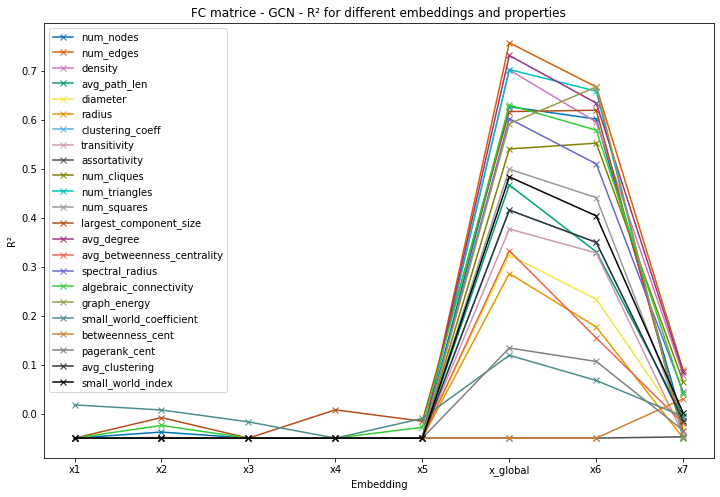

<Figure size 432x288 with 0 Axes>

In [17]:
#import plt
import matplotlib.pyplot as plt
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
#make a color list for the properties names but with different colors
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55),    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2),      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]
plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')

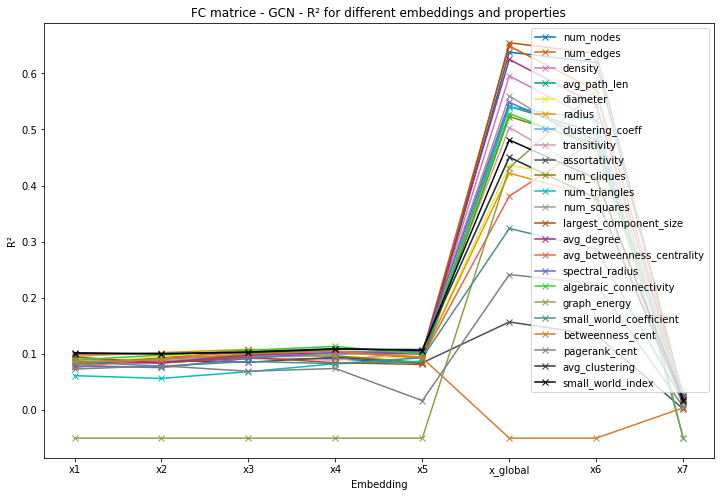

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figsize=(12, 8))
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']


for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_names_long)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)

    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')
    

### comparison with a gnn train on random (the y are shuffled)

In [ ]:
dataset = read_dataset_MDD()
MODEL = "GCN_w_edge_weight"
DATASET = "FC_MDD_suffled"

from models.models_FC import GCN_framework_wo_edge_weight as framework # import the model

gnn = framework(dataset,device="cpu")

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1-4): 4 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
#shuffle the y values of the dataset
import numpy as np
import torch

y = np.array([data.y for data in dataset])
np.random.shuffle(y)

#make y torch.int64, tensor([0]) instead of [0]
y = torch.tensor(y, dtype=torch.int64)

for i in range(len(dataset)):
    dataset[i].y = y[i]

In [ ]:
gnn.iterate()

Epoch: 020, Loss: 0.158, Test Loss: 0.831, Train Acc: 0.998 Test Acc: 0.509
Epoch: 040, Loss: 0.152, Test Loss: 0.867, Train Acc: 0.999 Test Acc: 0.527
Epoch: 060, Loss: 0.118, Test Loss: 0.772, Train Acc: 0.999 Test Acc: 0.491
Epoch: 080, Loss: 0.111, Test Loss: 0.756, Train Acc: 0.999 Test Acc: 0.491
Epoch: 100, Loss: 0.106, Test Loss: 0.807, Train Acc: 0.999 Test Acc: 0.509
Epoch: 120, Loss: 0.099, Test Loss: 0.786, Train Acc: 0.999 Test Acc: 0.473
Epoch: 140, Loss: 0.096, Test Loss: 0.761, Train Acc: 0.999 Test Acc: 0.527
Epoch: 160, Loss: 0.097, Test Loss: 0.748, Train Acc: 0.999 Test Acc: 0.509
Epoch: 180, Loss: 0.092, Test Loss: 0.767, Train Acc: 0.999 Test Acc: 0.473
Epoch: 200, Loss: 0.091, Test Loss: 0.763, Train Acc: 0.999 Test Acc: 0.473
Epoch: 220, Loss: 0.091, Test Loss: 0.769, Train Acc: 0.999 Test Acc: 0.455
Epoch: 240, Loss: 0.089, Test Loss: 0.766, Train Acc: 0.999 Test Acc: 0.473
Epoch: 260, Loss: 0.091, Test Loss: 0.781, Train Acc: 0.999 Test Acc: 0.473
Epoch: 280, 

In [ ]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")

In [ ]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [ ]:
gnn.evaluate()

In [ ]:
train_features, test_features = gnn.evaluate_with_features2()

In [ ]:
train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)

In [ ]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [ ]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

In [ ]:
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

In [ ]:
import matplotlib.pyplot as plt
colors_long = [
    (0.0, 0.45, 0.70),  # Blue
    (0.85, 0.37, 0.01),  # Orange
    (0.8, 0.47, 0.74),   # Magenta
    (0.0, 0.62, 0.45),   # Green
    (0.95, 0.90, 0.25),  # Yellow
    (0.9, 0.6, 0.0),     # Brown
    (0.35, 0.7, 0.9),    # Sky Blue
    (0.8, 0.6, 0.7),     # Light Pink
    (0.3, 0.3, 0.3),     # Dark Gray
    (0.5, 0.5, 0.0),     # Olive
    (0.0, 0.75, 0.75),   # Cyan
    (0.6, 0.6, 0.6),     # Light Gray
    (0.7, 0.3, 0.1),     # Dark Orange
    (0.6, 0.2, 0.5),     # Purple
    (0.9, 0.4, 0.3),     # Salmon
    (0.4, 0.4, 0.8),     # Light Blue
    (0.2, 0.8, 0.2),     # Light Green
    (0.6, 0.6, 0.3),     # Mustard
    (0.3, 0.55, 0.55)    # Teal
    (0.8, 0.5, 0.2),     # Dark Salmon
    (0.5, 0.5, 0.5),     # Gray
    (0.2, 0.2, 0.2)      # Black-Gray
    (0.0, 0.0, 0.0)      # Black
]

property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient', 'betweenness_cent', 'pagerank_cent', 'avg_clustering', 'small_world_index']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'test_R2_plot_long_random.png')

### Node embedding probing

/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

##### Node properties

In [ ]:
import networkx as nx
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties([gnn.dataset[i] for i in train_idx])
test_node_properties = compute_node_properties([gnn.dataset[i] for i in test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

In [ ]:
train_idx[0]

217

In [ ]:
len(train_node_properties), len(test_node_properties)

(1044, 55)

In [ ]:
# Check the length of the first three betweenness centralities of the three first graphs in the train set
[len(train_node_properties[i][2]) for i in range(15)]

[116, 116, 116, 116, 116, 116, 115, 113, 116, 116, 114, 115, 112, 115, 116]

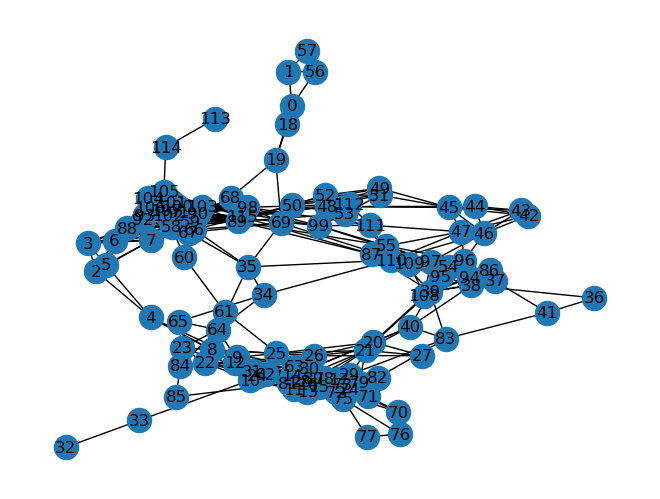

In [ ]:
import networkx as nx
# Ensure gnn.test_idx is a list of integers
test_idx = gnn.test_idx.tolist() if isinstance(gnn.test_idx, torch.Tensor) else gnn.test_idx

# Visualize the first graph of the test set to see if the properties are correct
G = nx.from_edgelist(gnn.dataset[test_idx[0]].edge_index.t().tolist())
nx.draw(G, with_labels=True)


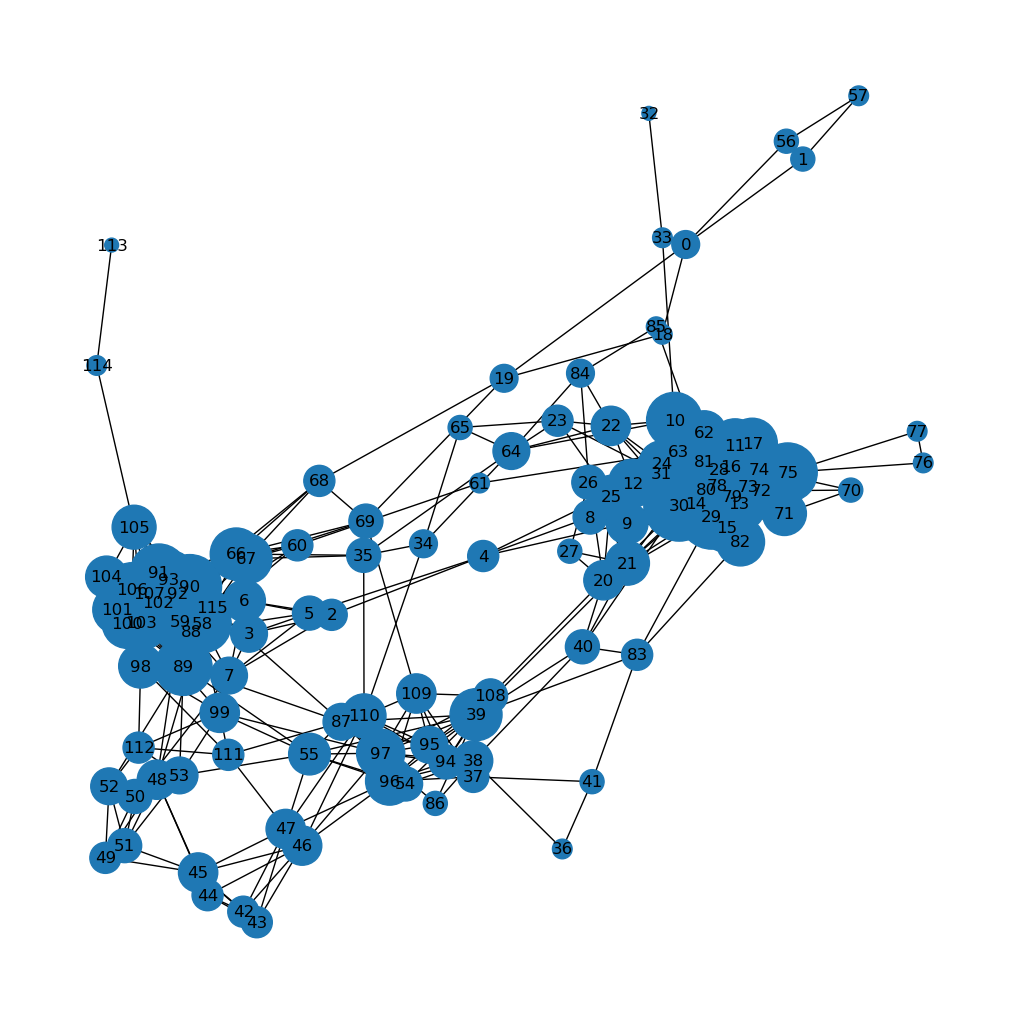

In [ ]:
import matplotlib.pyplot as plt
#represent the node degrees of the first graph in the test set
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 100 for v in node_degrees], cmap='viridis')
plt.show()

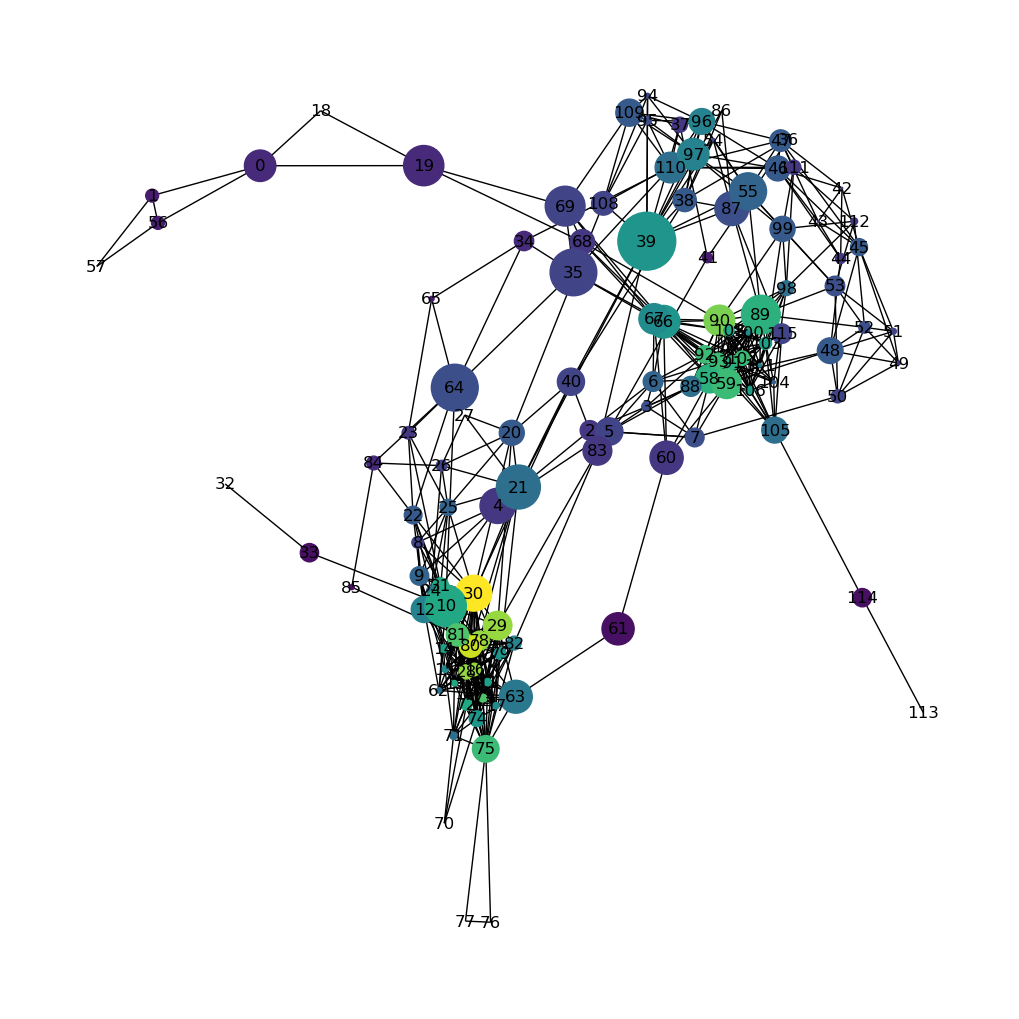

In [ ]:
#represent the properties of betweenness centrality on the graph by chaging the size of the nodes
betweenness_centrality = test_node_properties[0][2]
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 10000 for v in betweenness_centrality], node_color=node_degrees, cmap='viridis')
plt.show()


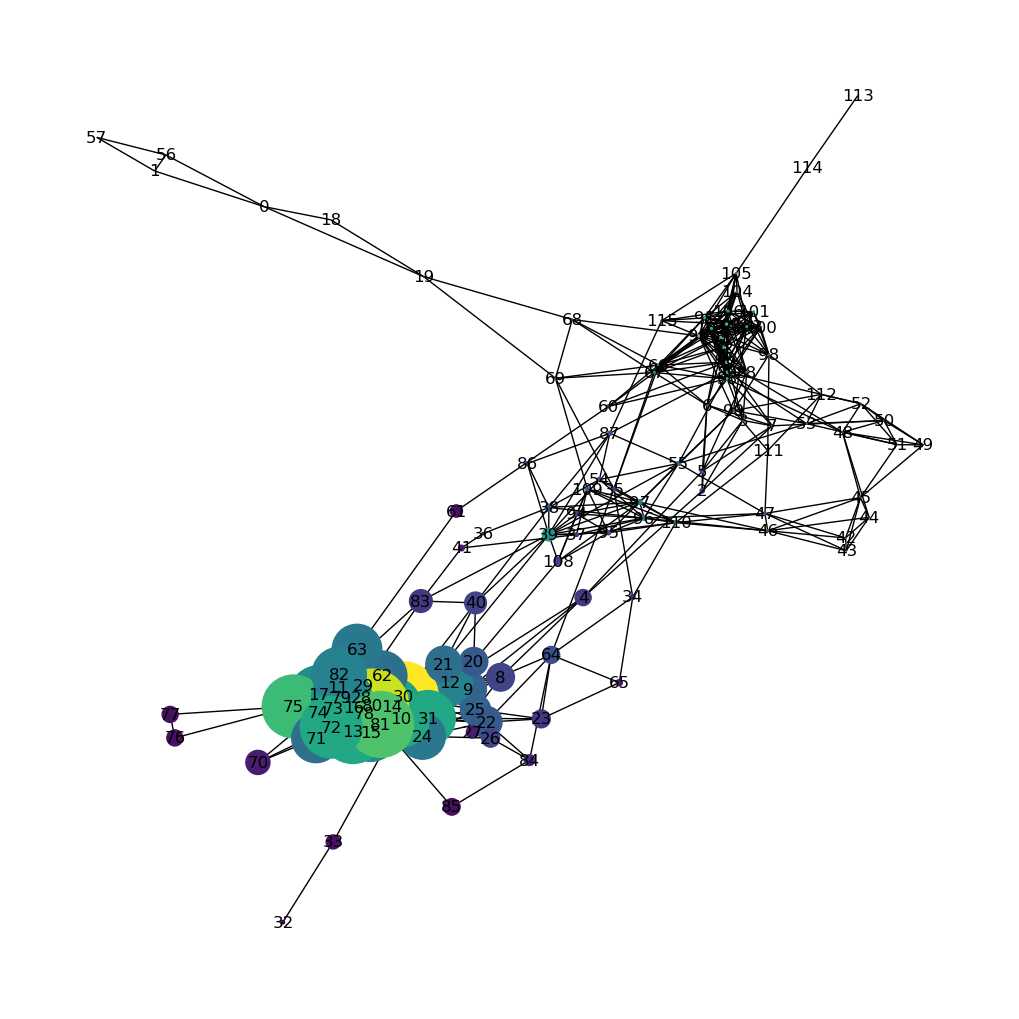

In [ ]:
#same for eigenvector centrality
eigenvector_centralities = test_node_properties[0][3]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 10000 for v in eigenvector_centralities], node_color=node_degrees, cmap='viridis')
plt.show()

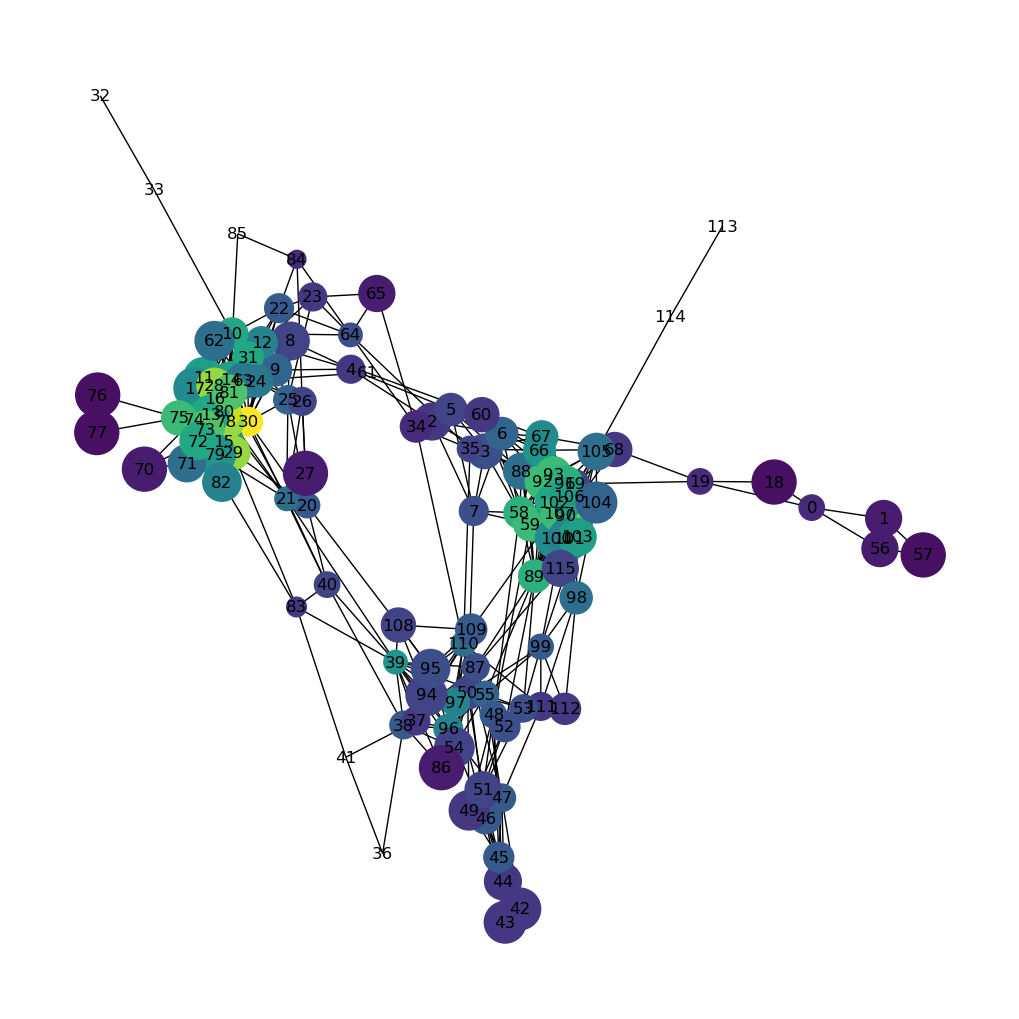

In [ ]:
#same for local clustering coefficients
Local_clustering_coefficients = test_node_properties[0][4]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=[v * 1000 for v in Local_clustering_coefficients], node_color=node_degrees, cmap='viridis')
plt.show()

We see that for each graph, the length of the betweenness centralities, and in general the length of properties, are equal to the number of nodes in the graph and thus
is equal to the length of the x matrix in the features. 

##### Node embeddings

In [ ]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.Size([116, 128])
features[4].shape:  torch.Size([116, 128])
train_features[0][0].shape:  (116, 128)
len of features:  5
features[0].shape:  torch.Size([116, 128])
features[1].shape:  torch.Size([116, 128])
features[2].shape:  torch.Size([116, 128])
features[3].shape:  torch.

In [ ]:
len(train_features), len(test_features)

(1044, 55)

In [ ]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

Feature 1 shape: (116, 128)
Feature 2 shape: (116, 128)
Feature 3 shape: (116, 128)
Feature 4 shape: (116, 128)
Feature 5 shape: (116, 128)


In [ ]:
train_features[1][0][115]

array([-0.37685975,  1.6929058 ,  1.7549721 , -0.5988426 , -0.70699286,
       -0.6436017 , -0.5976539 , -0.58719116, -0.6589397 , -0.58917546,
       -0.6371779 ,  0.7570742 , -0.67844796, -0.5799983 ,  0.99585336,
        0.7851752 , -0.72770834,  2.5991597 , -0.6501186 , -0.67277133,
        0.8801811 ,  3.412127  , -0.62779766, -0.63370866, -0.6870711 ,
        0.9279621 ,  1.7032547 , -0.6746877 , -0.17400467, -0.6686538 ,
       -0.65484655, -0.6692904 , -0.6735106 , -0.6526415 ,  0.69125366,
        0.07277119, -0.6910381 , -0.6376403 , -0.5185264 , -0.6976487 ,
       -0.6681054 , -0.71855813, -0.71772814,  0.52832973, -0.73103005,
        0.28918487, -0.66227067, -0.6802141 , -0.6193607 , -0.67815524,
       -0.6069186 ,  1.8839588 , -0.59435576, -0.02621281, -0.7132852 ,
       -0.68886244, -0.6890108 , -0.6547946 ,  0.6078467 , -0.701213  ,
        1.2887506 ,  2.127263  , -0.58606315,  2.8298755 , -0.18379873,
       -0.5403075 , -0.7609473 , -0.32233348,  0.40016913, -0.10

#### Embedding probing

##### Probing for the top 3 nodes on train_features only and averaging the results of the different diagnostif classifiers

In [ ]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=10):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [ ]:

# Get the top 3 nodes for local clustering coefficient and eigenvector centrality
top_nodes_degrees = [get_top_nodes(graph_props[0], 10) for graph_props in train_node_properties]  # Assuming 0th index is for node degrees
top_nodes_clustering = [get_top_nodes(graph_props[1], 10) for graph_props in train_node_properties]  # Assuming 1st index is for clustering coefficient
top_nodes_betweenness = [get_top_nodes(graph_props[2], 10) for graph_props in train_node_properties]  # Assuming 2nd index is for betweenness centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 10) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 10) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality


In [ ]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(5000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [ ]:
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_degrees)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_betweenness)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

C:\Users\tomdu\AppData\Local\Temp\ipykernel_15848\2885731528.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0, Loss: 337.63140869140625
Epoch 10, Loss: 325.15325927734375
Epoch 20, Loss: 317.4220275878906
Epoch 30, Loss: 311.8927307128906
Epoch 40, Loss: 307.3858337402344
Epoch 50, Loss: 303.4187316894531
Epoch 60, Loss: 299.7639465332031
Epoch 70, Loss: 296.2999267578125
Epoch 80, Loss: 292.96038818359375
Epoch 90, Loss: 289.7093200683594
Epoch 100, Loss: 286.5265808105469
Epoch 110, Loss: 283.3989562988281
Epoch 120, Loss: 280.3171691894531
Epoch 130, Loss: 277.27484130859375
Epoch 140, Loss: 274.2673645019531
Epoch 150, Loss: 271.29156494140625
Epoch 160, Loss: 268.34521484375
Epoch 170, Loss: 265.42669677734375
Epoch 180, Loss: 262.5349426269531
Epoch 190, Loss: 259.6691589355469
Epoch 200, Loss: 256.8288269042969
Epoch 210, Loss: 254.01341247558594
Epoch 220, Loss: 251.22276306152344
Epoch 230, Loss: 248.4565887451172
Epoch 240, Loss: 245.7146759033203
Epoch 250, Loss: 242.9969024658203
Epoch 260, Loss: 240.3031463623047
Epoch 270, Loss: 237.63323974609375
Epoch 280, Loss: 234.987

##### Probing for the top 1 nodes with diagnostic classifier trained on the train set and test on the test set

Processing property: Node Degrees
Processing property: Clustering Coefficients
Processing property: Betweenness Centralities
Processing property: Eigenvector Centralities
Processing property: Local Clustering Coefficients


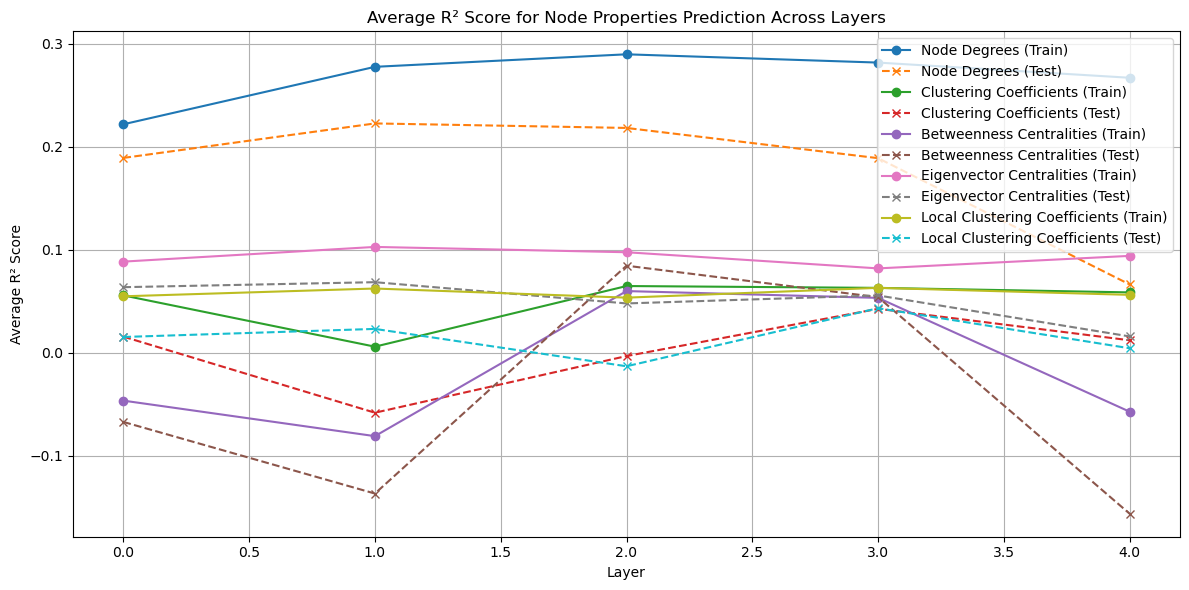

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define Linear Model for probing (diagnostic classifier)
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Prepare the data for probing classifier
def prepare_regression_data(features, properties, property_index, top_n_nodes=10):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        top_nodes_indices = get_top_nodes(properties[i][property_index], top_n=top_n_nodes)
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices:
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Train and evaluate the probing classifier for each layer
def train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers):
    r2_scores_train = []
    r2_scores_test = []
    
    for layer in range(len(X_train_layers)):
        X_train = X_train_layers[layer]
        y_train = y_train_layers[layer]
        X_test = X_test_layers[layer]
        y_test = y_test_layers[layer]
        
        model = LinearModel(X_train.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X_train.float())
            loss = criterion(outputs, y_train.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions_train = model(X_train.float()).view(-1)
            predictions_test = model(X_test.float()).view(-1)
            r2_train = r2_score(y_train.float(), predictions_train)
            r2_test = r2_score(y_test.float(), predictions_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
    
    return r2_scores_train, r2_scores_test

# Aggregate R² scores across all graphs
def aggregate_r2_scores(features_train, properties_train, features_test, properties_test, property_index):
    X_train_layers, y_train_layers = prepare_regression_data(features_train, properties_train, property_index)
    X_test_layers, y_test_layers = prepare_regression_data(features_test, properties_test, property_index)
    
    r2_scores_train, r2_scores_test = train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers)
    
    return r2_scores_train, r2_scores_test

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers
avg_r2_train_dict = {name: [] for name in property_names}
avg_r2_test_dict = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property: {prop_name}")
    avg_r2_train_dict[prop_name], avg_r2_test_dict[prop_name] = aggregate_r2_scores(train_features, train_node_properties, test_features, test_node_properties, prop_idx)

# Plotting the average R² scores across layers for each property
layers = np.arange(len(avg_r2_train_dict[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

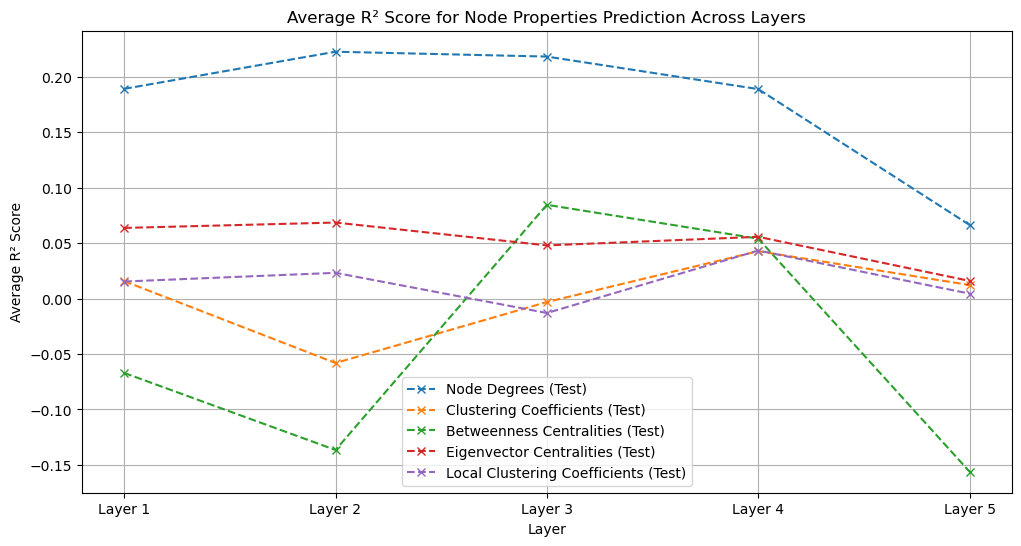

In [ ]:
#plot only test results
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
#x axis called layer 1, layer 2, etc
plt.xticks(range(len(layers)), [f'Layer {i+1}' for i in layers])           
plt.grid(True)

y=1 and y=0 as two different plots

Processing property for y=0: Node Degrees
Processing property for y=0: Clustering Coefficients
Processing property for y=0: Betweenness Centralities
Processing property for y=0: Eigenvector Centralities
Processing property for y=0: Local Clustering Coefficients
Processing property for y=1: Node Degrees
Processing property for y=1: Clustering Coefficients
Processing property for y=1: Betweenness Centralities
Processing property for y=1: Eigenvector Centralities
Processing property for y=1: Local Clustering Coefficients


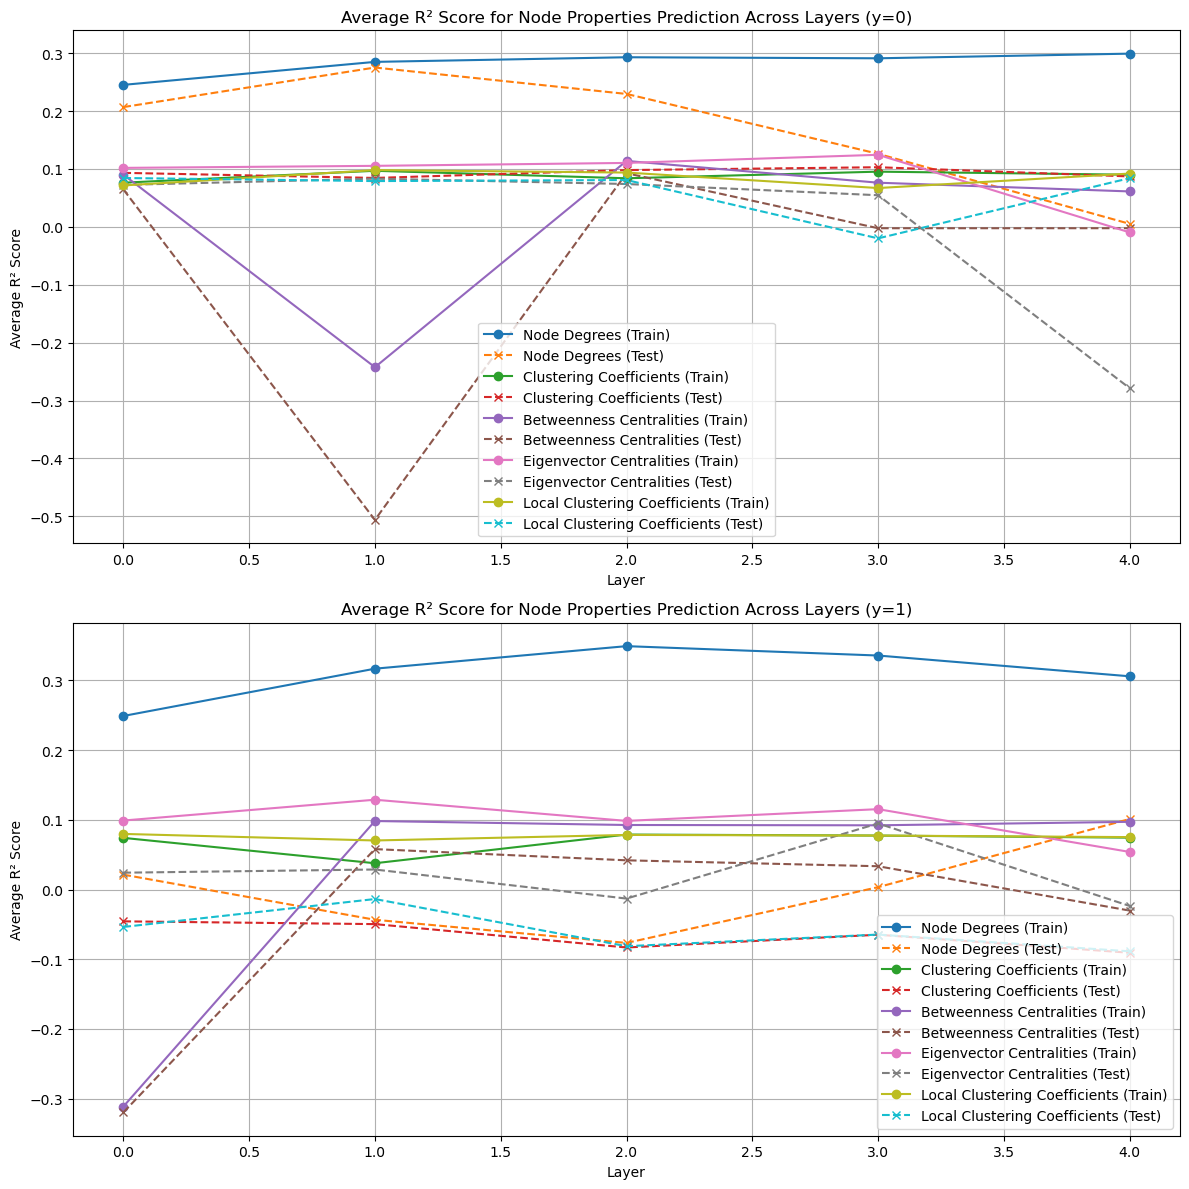

In [ ]:
# Extract labels from the dataset using train_idx_list and test_idx_list
train_idx_list = gnn.train_idx.tolist()
test_idx_list = gnn.test_idx.tolist()

train_labels = [gnn.dataset[i].y.item() for i in train_idx_list]
test_labels = [gnn.dataset[i].y.item() for i in test_idx_list]

# Split the dataset by label y=0 and y=1
def split_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, label in enumerate(labels):
        if label == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

# Assuming you have train_features, train_node_properties, test_features, test_node_properties from your GNN
train_features_0, train_node_properties_0, train_features_1, train_node_properties_1 = split_by_label(train_features, train_node_properties, train_labels)
test_features_0, test_node_properties_0, test_features_1, test_node_properties_1 = split_by_label(test_features, test_node_properties, test_labels)

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers for y=0 and y=1
avg_r2_train_dict_0 = {name: [] for name in property_names}
avg_r2_test_dict_0 = {name: [] for name in property_names}
avg_r2_train_dict_1 = {name: [] for name in property_names}
avg_r2_test_dict_1 = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property for y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=0: {prop_name}")
    avg_r2_train_dict_0[prop_name], avg_r2_test_dict_0[prop_name] = aggregate_r2_scores(train_features_0, train_node_properties_0, test_features_0, test_node_properties_0, prop_idx)

# Train and evaluate the probing classifier for each property for y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property for y=1: {prop_name}")
    avg_r2_train_dict_1[prop_name], avg_r2_test_dict_1[prop_name] = aggregate_r2_scores(train_features_1, train_node_properties_1, test_features_1, test_node_properties_1, prop_idx)

# Plotting the average R² scores across layers for each property, separately for y=0 and y=1
layers = np.arange(len(avg_r2_train_dict_0[property_names[0]]))

plt.figure(figsize=(12, 12))

# Plot for y=0
plt.subplot(2, 1, 1)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_0[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_0[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=0)')
plt.legend()
plt.grid(True)

# Plot for y=1
plt.subplot(2, 1, 2)
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict_1[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict_1[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
